# Lead score case study 

## Table of Contents


1. Problem Statement

2. Reading and Understanding Data

3. Data Cleansing

4. EDA

  a. Univariate Analysis
  b. Bivariate Analysis

5. Creating dummy variables and Splitting the data into train and test sets

6. Rescaling numerical features

7. Feature elimination using RFE

8. Model Building

9. Metrics on Training set and Finding Optimal Cutoff Probability

10. Making Predictions on Test set

11. Lead Scores

# 1. Problem Statement:

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses.

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%.

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to every

The company wants to —

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.one.

# 2. Reading and Understanding data

In [366]:
# importing necessary libraries 

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, accuracy_score,classification_report

import warnings
warnings.filterwarnings("ignore")

# trying to see all column names 

pd.set_option("display.max_columns", 100)


In [367]:
# getting dataframe 

lead_score = pd.read_csv('Leads.csv')

# checking some records 

lead_score.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [368]:
# ckecking info about dataframe

lead_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [369]:
# checking statistical summary of a dataframe 

lead_score.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [370]:
# checking balance ratio of target variable  

round(sum((lead_score.Converted)/len(lead_score.Converted)*100),2)

38.54

## inferences 

* After understanding the data, we can see that

1. Null values are present in multiple columns, which are needs to be treated
2. outliers are present in Total Visits, Total time spent on website and Page views per visit columns which are needed to be handled
3. Balnce ratio of dataset is ~ 38% . i.e, 38% of Leads are being converted

# 3. data cleaning 

### dealing with null values 

In [371]:
# checking null counts in columns 

lead_score.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [372]:
# finding percentage of null counts 

null_perc = round(100*(lead_score.isnull().sum()/len(lead_score)),2)

In [373]:
null_perc

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [374]:
# checking rows which have more than 40%  of null values 

null_perc = null_perc[null_perc>40]

null_perc

Lead Quality                   51.59
Asymmetrique Activity Index    45.65
Asymmetrique Profile Index     45.65
Asymmetrique Activity Score    45.65
Asymmetrique Profile Score     45.65
dtype: float64

In [375]:
# checking value counts present in those columns

lead_score['Lead Quality'].value_counts()

Lead Quality
Might be             1560
Not Sure             1092
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: count, dtype: int64

In [376]:
lead_score['Asymmetrique Activity Index'].value_counts()

Asymmetrique Activity Index
02.Medium    3839
01.High       821
03.Low        362
Name: count, dtype: int64

In [377]:
lead_score['Asymmetrique Profile Index'].value_counts()

Asymmetrique Profile Index
02.Medium    2788
01.High      2203
03.Low         31
Name: count, dtype: int64

In [378]:
lead_score['Asymmetrique Activity Score'].value_counts()

Asymmetrique Activity Score
14.0    1771
15.0    1293
13.0     775
16.0     467
17.0     349
12.0     196
11.0      95
10.0      57
9.0        9
18.0       5
8.0        4
7.0        1
Name: count, dtype: int64

In [379]:
lead_score['Asymmetrique Profile Score'].value_counts()

Asymmetrique Profile Score
15.0    1759
18.0    1071
16.0     599
17.0     579
20.0     308
19.0     245
14.0     226
13.0     204
12.0      22
11.0       9
Name: count, dtype: int64

In [380]:
# verifying dataframe 

lead_score.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened


In [381]:
# checking column names of a dataframe 

lead_score.columns.tolist()

['Prospect ID',
 'Lead Number',
 'Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Converted',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'Last Activity',
 'Country',
 'Specialization',
 'How did you hear about X Education',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Tags',
 'Lead Quality',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'Lead Profile',
 'City',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

### we should drop the columns which have more than 40 % null values 

In [382]:
# making a dataframe of columns which have more than 40% of null values 

null_cols = ['Lead Quality','Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score']

In [383]:
# dropping those columns 

lead_score = lead_score.drop(['Lead Quality','Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score'],axis = 1)

In [384]:
# verifying the dataframe 

lead_score.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Select,Select,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Select,Select,No,No,Email Opened


In [385]:
# rechecking columns present in data after dropping the columns 

lead_score.columns.tolist()

['Prospect ID',
 'Lead Number',
 'Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Converted',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'Last Activity',
 'Country',
 'Specialization',
 'How did you hear about X Education',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Tags',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'Lead Profile',
 'City',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

In [386]:
# verifying the dataframe 

lead_score.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Select,Select,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Select,Select,No,No,Email Opened


In [387]:
# checking if any duplicates present in a dataframe 

print('Number of duplicates present in \'Prospect ID\' column',sum(lead_score.duplicated(subset = 'Prospect ID')))
print('Number of duplicates present in \'Lead Number\' column',sum(lead_score.duplicated(subset = 'Lead Number')))

Number of duplicates present in 'Prospect ID' column 0
Number of duplicates present in 'Lead Number' column 0


In [388]:
# verifying the dataframe 

lead_score.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Select,Select,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Select,Select,No,No,Email Opened


In [389]:
# renaming the columns which have very long names 

lead_score.rename(columns = {'Prospect ID':'Prospect_ID',
                              'Lead Number':'Lead_Number',
                             'Lead Origin':'Lead_Origin',
                            'Lead Source':'Lead_source',
                              'Do Not Email':'No_email',
                              'Do Not Call':'No_calls',
                              'Total Time Spent on Website':'Time_spent',
                              'Page Views Per Visit':'Page_views',
                             'Last Activity':'Last_activity',
                              'What is your current occupation':'Occupation',
                              'What matters most to you in choosing a course':'Reason_for_Choosing',
                               'Newspaper Article':'News_article',
                               'X Education Forums':'Forums',
                              'Digital Advertisement':'Ads',
                               'Through Recommendations':'Recommendation',
                              'Receive More Updates About Our Courses':'Course_updates',
                               'Update me on Supply Chain Content':'Updates',
                              'Get updates on DM Content':'Content_updates',
                               'I agree to pay the amount through cheque':'Pay_cheque',
                              'A free copy of Mastering The Interview':'Free_copy',
                               'Last Notable Activity':'Last_notable_activity'
                            ,'How did you hear about X Education':'got information'},
                                inplace = True)

In [390]:
# verifying the dataframe 

lead_score.head(2)

,Prospect_ID,Lead_Number,Lead_Origin,Lead_source,No_email,No_calls,Converted,TotalVisits,Time_spent,Page_views,Last_activity,Country,Specialization,got information,Occupation,Reason_for_Choosing,Search,Magazine,News_article,Forums,Newspaper,Ads,Recommendation,Course_updates,Tags,Updates,Content_updates,Lead Profile,City,Pay_cheque,Free_copy,Last_notable_activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Select,Select,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Select,Select,No,No,Email Opened


In [392]:
# some columns have select value , so replacing select with nan 

lead_score = lead_score.replace('select',np.NaN)

In [393]:
# checking null percent again 

null_perc = round(100*(lead_score.isnull().sum()/len(lead_score)),2)

In [394]:
null_perc

Prospect_ID               0.00
Lead_Number               0.00
Lead_Origin               0.00
Lead_source               0.39
No_email                  0.00
No_calls                  0.00
Converted                 0.00
TotalVisits               1.48
Time_spent                0.00
Page_views                1.48
Last_activity             1.11
Country                  26.63
Specialization           15.56
got information          23.89
Occupation               29.11
Reason_for_Choosing      29.32
Search                    0.00
Magazine                  0.00
News_article              0.00
Forums                    0.00
Newspaper                 0.00
Ads                       0.00
Recommendation            0.00
Course_updates            0.00
Tags                     36.29
Updates                   0.00
Content_updates           0.00
Lead Profile             29.32
City                     15.37
Pay_cheque                0.00
Free_copy                 0.00
Last_notable_activity     0.00
dtype: f

### as we don't need 'PROSPECT ID' & some columns for analysis so we should have drop that columns 

In [395]:
# dropping unused columns 

lead_score = lead_score.drop(['Updates','Last_activity','Prospect_ID'],axis = 1)

In [396]:
# verifying the dataframe 

lead_score.head(2)

,Lead_Number,Lead_Origin,Lead_source,No_email,No_calls,Converted,TotalVisits,Time_spent,Page_views,Country,Specialization,got information,Occupation,Reason_for_Choosing,Search,Magazine,News_article,Forums,Newspaper,Ads,Recommendation,Course_updates,Tags,Content_updates,Lead Profile,City,Pay_cheque,Free_copy,Last_notable_activity
0,660737,API,Olark Chat,No,No,0,0.0,0,0.0,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,Select,Select,No,No,Modified
1,660728,API,Organic Search,No,No,0,5.0,674,2.5,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,Select,Select,No,No,Email Opened


### imputing missing values 

In [397]:
# categorical variables

for col in lead_score.columns:
    if lead_score[col].dtype == 'object':
        lead_score[col].fillna(lead_score[col].mode()[0],inplace = True)

In [398]:
# numerical variables 

for col in lead_score.columns:
    if lead_score[col].dtype == 'int64' or lead_score[col].dtype == 'float64':
        lead_score[col].fillna(lead_score[col].mode()[0],inplace = True)

In [399]:
# checking null percent after imputing missing values 

null_perc = round(100*(lead_score.isnull().sum()/len(lead_score)),2)

In [400]:
null_perc

Lead_Number              0.0
Lead_Origin              0.0
Lead_source              0.0
No_email                 0.0
No_calls                 0.0
Converted                0.0
TotalVisits              0.0
Time_spent               0.0
Page_views               0.0
Country                  0.0
Specialization           0.0
got information          0.0
Occupation               0.0
Reason_for_Choosing      0.0
Search                   0.0
Magazine                 0.0
News_article             0.0
Forums                   0.0
Newspaper                0.0
Ads                      0.0
Recommendation           0.0
Course_updates           0.0
Tags                     0.0
Content_updates          0.0
Lead Profile             0.0
City                     0.0
Pay_cheque               0.0
Free_copy                0.0
Last_notable_activity    0.0
dtype: float64

In [401]:
# verifying the dataframe

lead_score.head(2)

,Lead_Number,Lead_Origin,Lead_source,No_email,No_calls,Converted,TotalVisits,Time_spent,Page_views,Country,Specialization,got information,Occupation,Reason_for_Choosing,Search,Magazine,News_article,Forums,Newspaper,Ads,Recommendation,Course_updates,Tags,Content_updates,Lead Profile,City,Pay_cheque,Free_copy,Last_notable_activity
0,660737,API,Olark Chat,No,No,0,0.0,0,0.0,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,Select,Select,No,No,Modified
1,660728,API,Organic Search,No,No,0,5.0,674,2.5,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,Select,Select,No,No,Email Opened


## 4. EDA

### 4.a. univariate analysis - (categorical-categorical )

value counts for Lead_Origin column:

Lead_Origin
Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: proportion, dtype: float64
..................................................

mode of Lead_Origin column: Landing Page Submission

..................................................


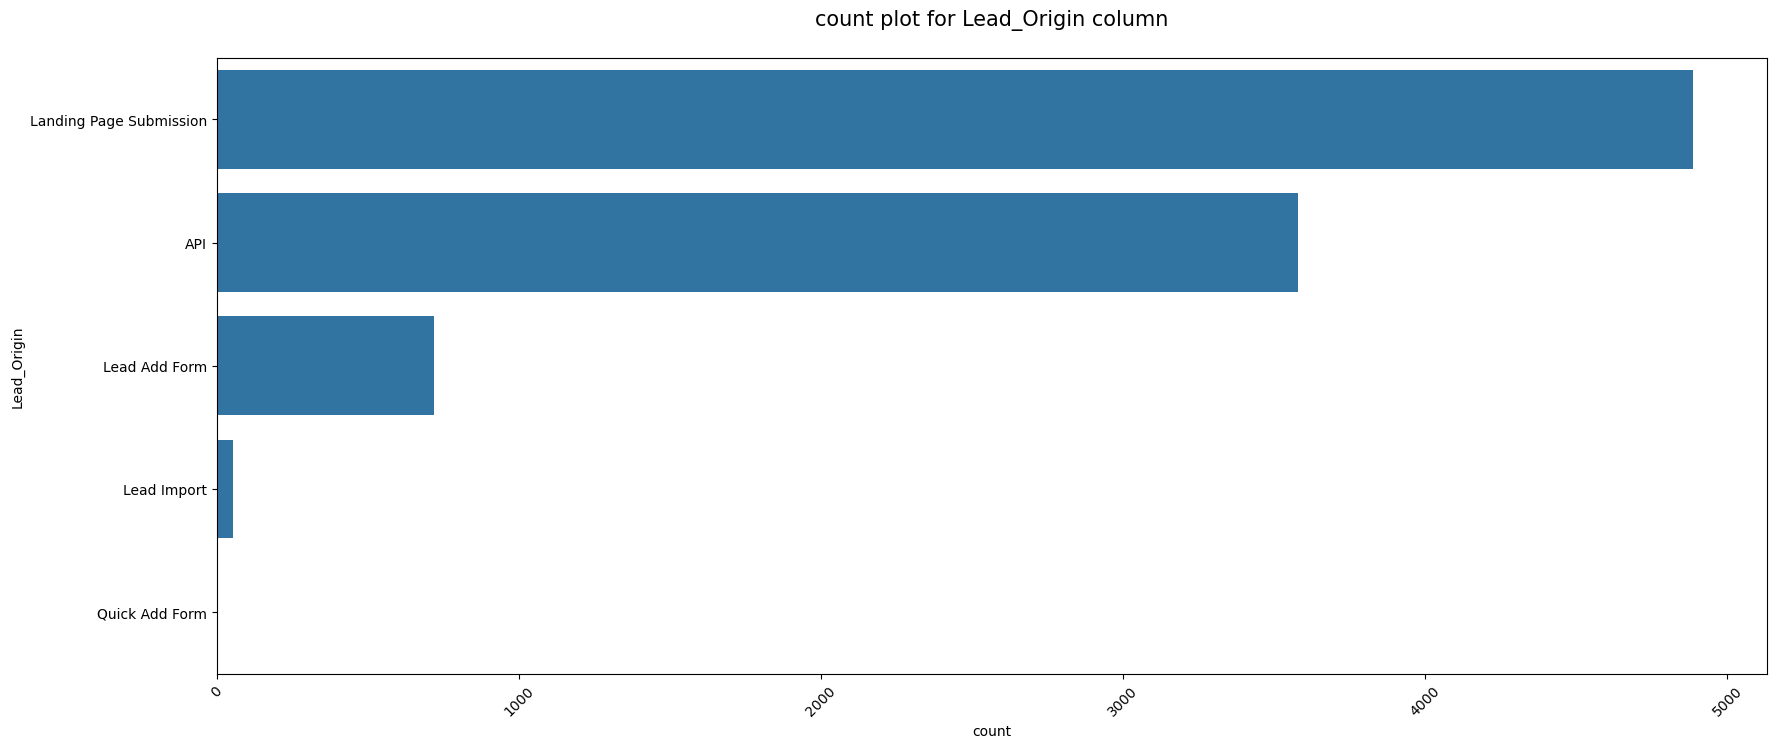


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Lead_source column:

Lead_source
Google               0.314286
Direct Traffic       0.275216
Olark Chat           0.189935
Organic Search       0.124892
Reference            0.057792
Welingak Website     0.015368
Referral Sites       0.013528
Facebook             0.005952
bing                 0.000649
google               0.000541
Click2call           0.000433
Press_Release        0.000216
Social Media         0.000216
Live Chat            0.000216
youtubechannel       0.000108
testone              0.000108
Pay per Click Ads    0.000108
welearnblog_Home     0.000108
WeLearn              0.000108
blog                 0.000108
NC_EDM               0.000108
Name: proportion, dtype: float64
..................................................

mode of Lead_source column: Google

..................................................


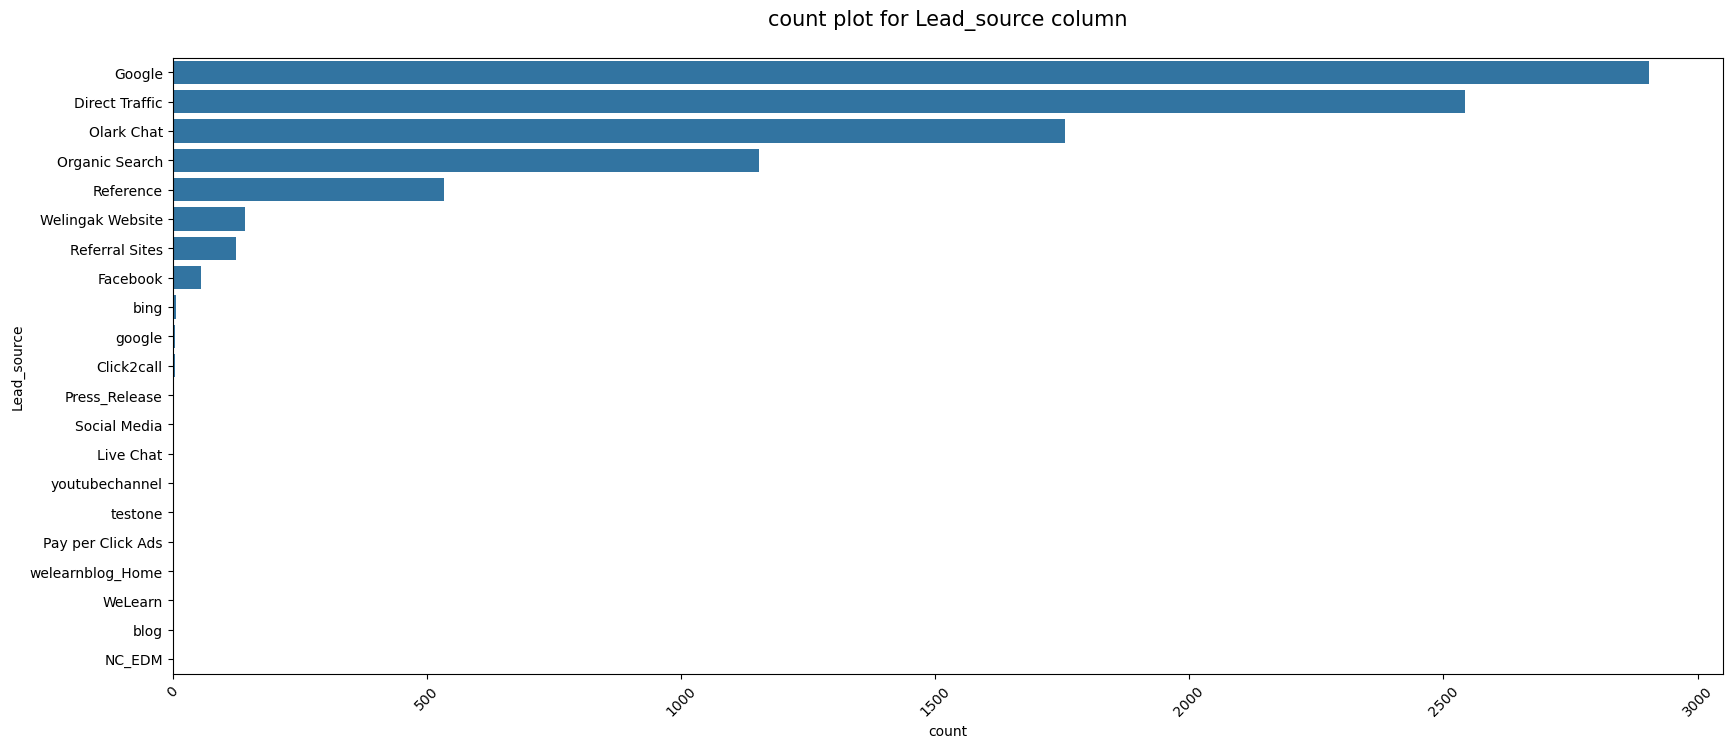


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for No_email column:

No_email
No     0.920563
Yes    0.079437
Name: proportion, dtype: float64
..................................................

mode of No_email column: No

..................................................


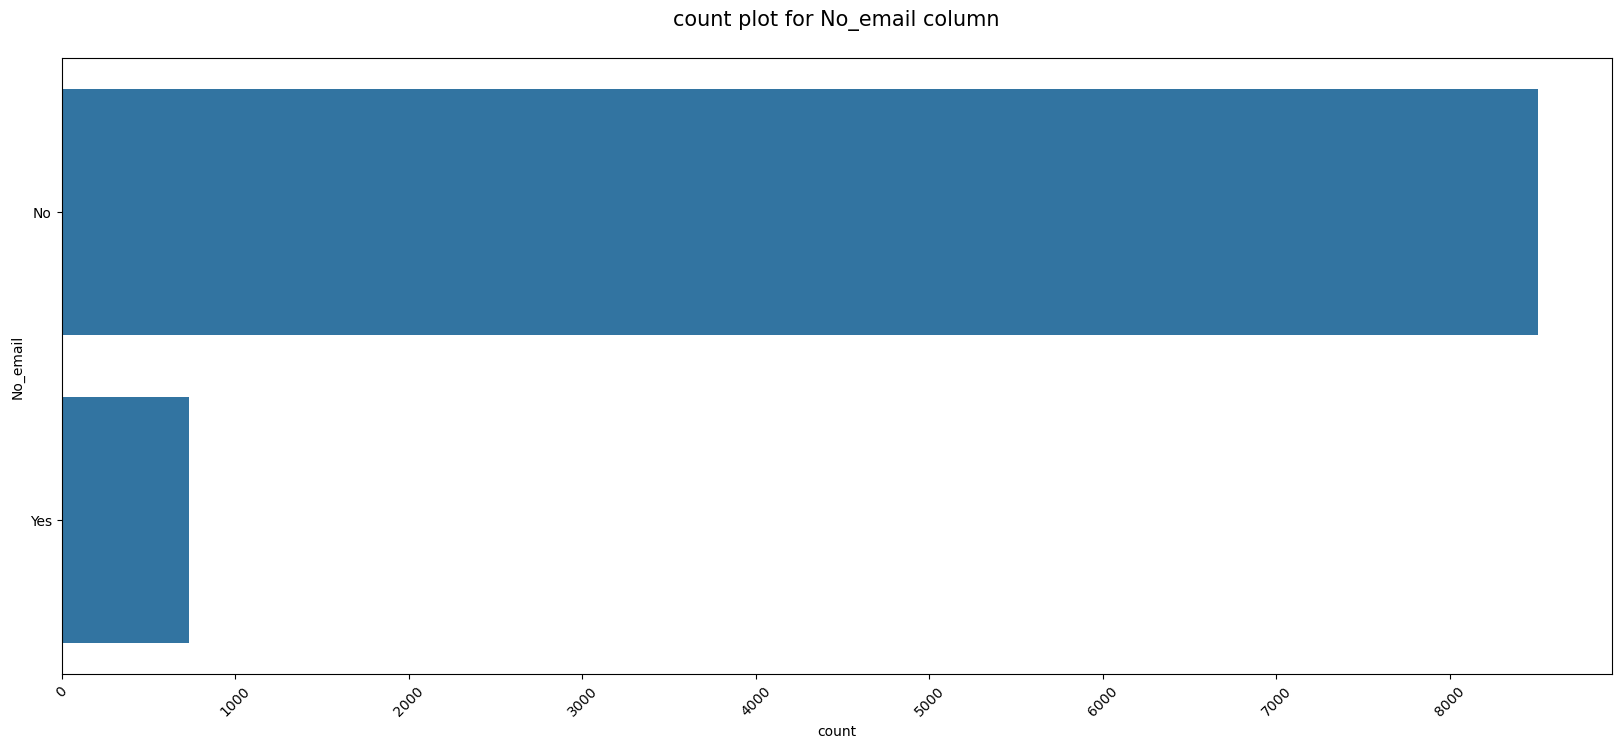


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for No_calls column:

No_calls
No     0.999784
Yes    0.000216
Name: proportion, dtype: float64
..................................................

mode of No_calls column: No

..................................................


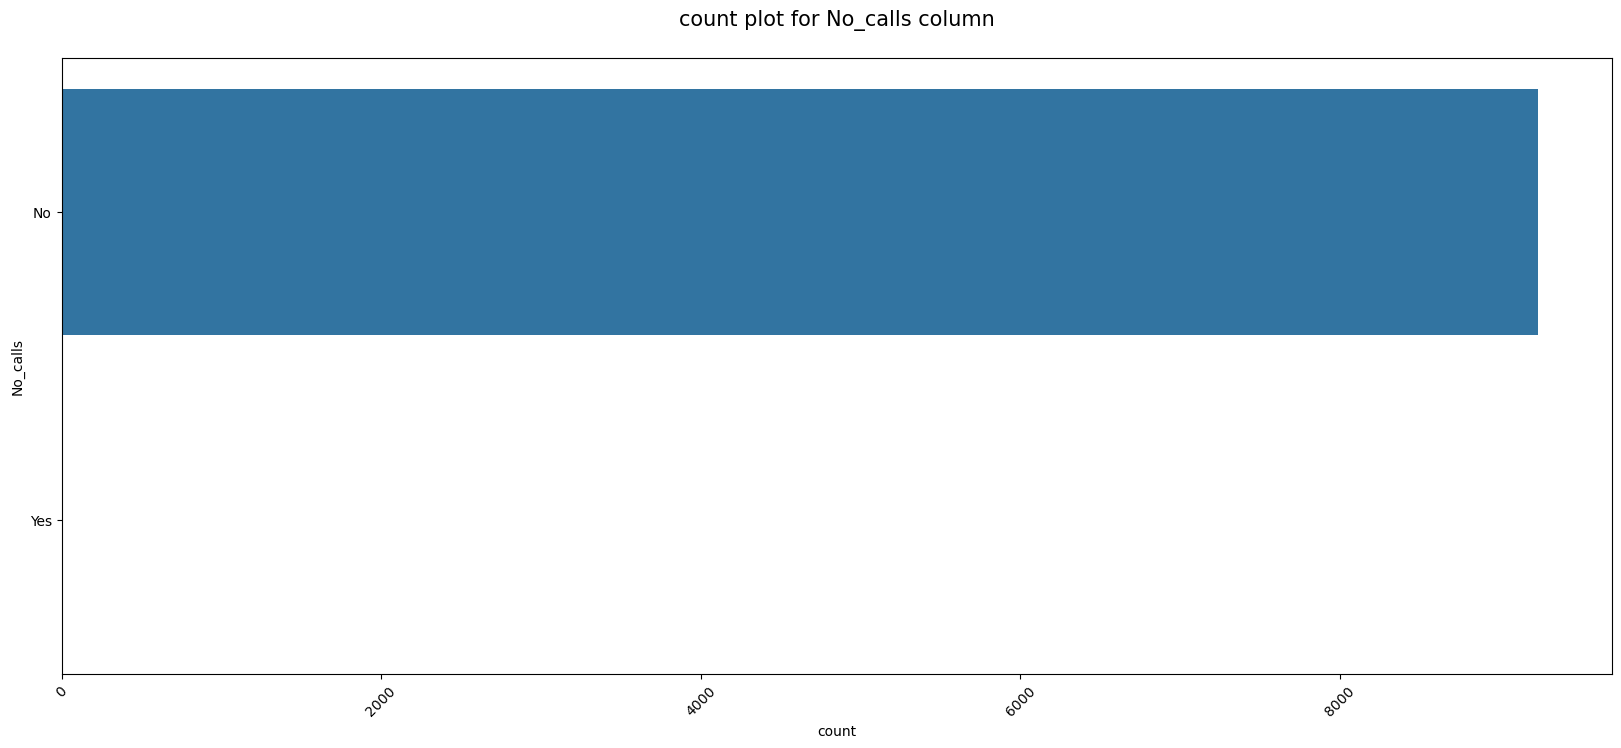


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Country column:

Country
India                   0.968939
United States           0.007468
United Arab Emirates    0.005736
Singapore               0.002597
Saudi Arabia            0.002273
United Kingdom          0.001623
Australia               0.001407
Qatar                   0.001082
Hong Kong               0.000758
Bahrain                 0.000758
France                  0.000649
Oman                    0.000649
unknown                 0.000541
South Africa            0.000433
Nigeria                 0.000433
Germany                 0.000433
Kuwait                  0.000433
Canada                  0.000433
Sweden                  0.000325
Belgium                 0.000216
Philippines             0.000216
Ghana                   0.000216
Netherlands             0.000216
China                   0.000216
Italy                   0.000216
Bangladesh              0.000216
Uganda                  0.000216
Asia/

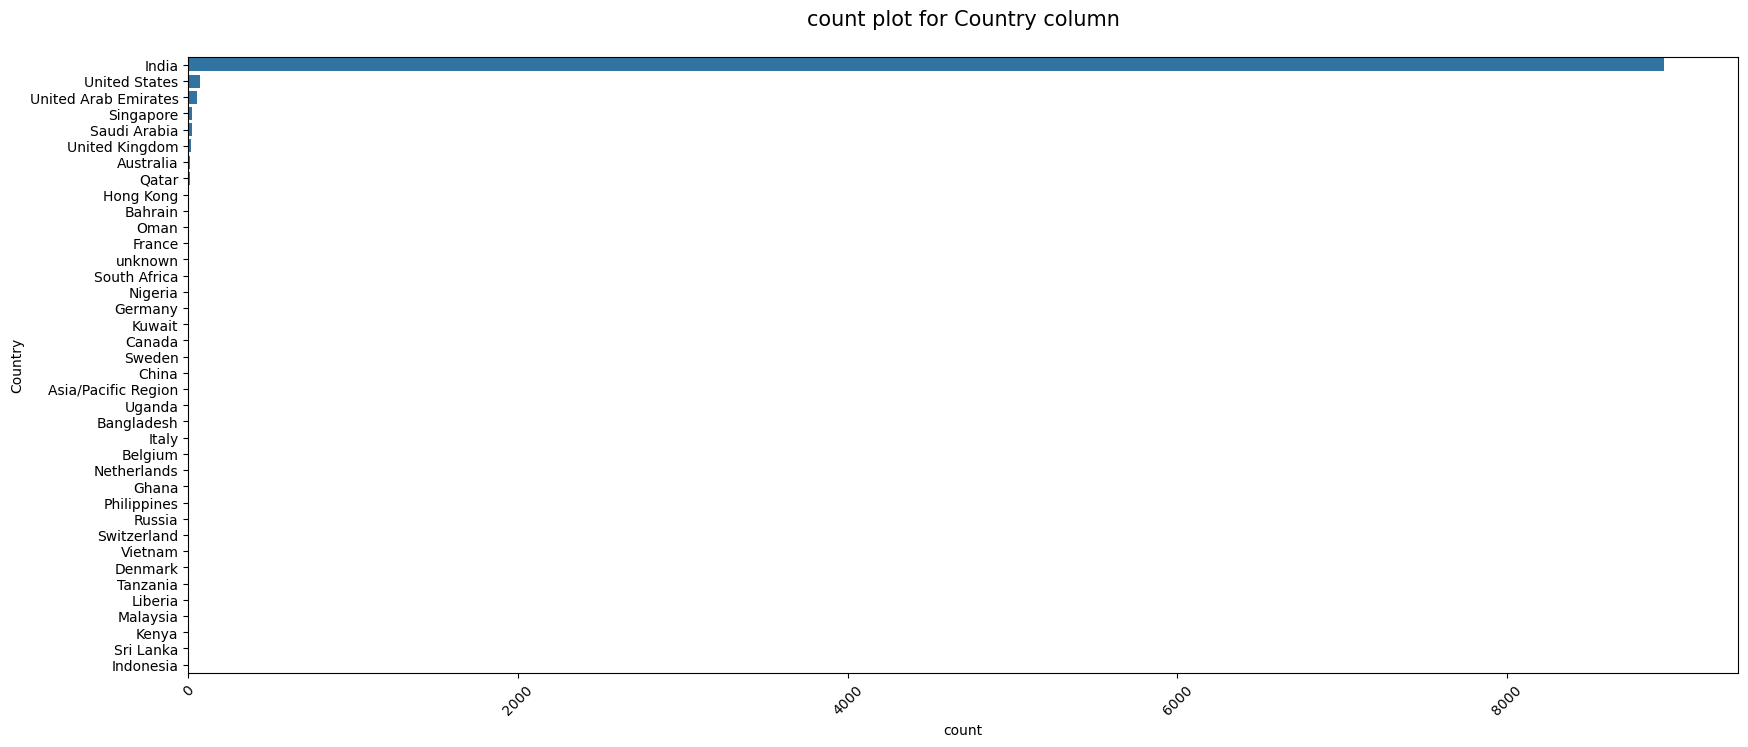


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Specialization column:

Specialization
Select                               0.365801
Finance Management                   0.105628
Human Resource Management            0.091775
Marketing Management                 0.090693
Operations Management                0.054437
Business Administration              0.043615
IT Projects Management               0.039610
Supply Chain Management              0.037771
Banking, Investment And Insurance    0.036580
Media and Advertising                0.021970
Travel and Tourism                   0.021970
International Business               0.019264
Healthcare Management                0.017208
Hospitality Management               0.012338
E-COMMERCE                           0.012121
Retail Management                    0.010823
Rural and Agribusiness               0.007900
E-Business                           0.006169
Services Excellence                  0.004329
Name: pr

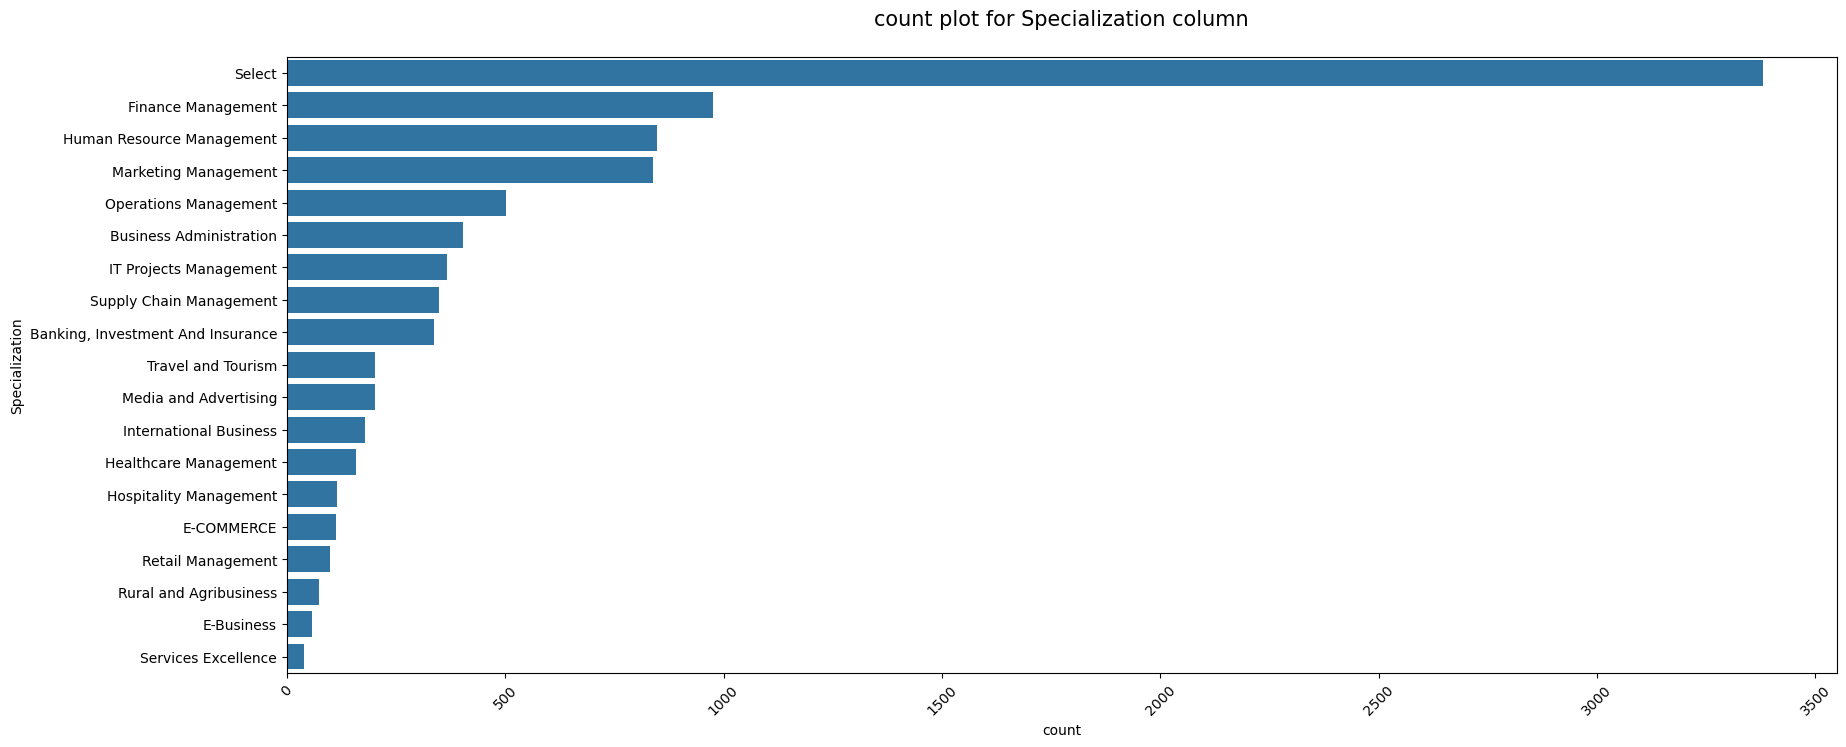


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for got information column:

got information
Select                   0.784632
Online Search            0.087446
Word Of Mouth            0.037662
Student of SomeSchool    0.033550
Other                    0.020130
Multiple Sources         0.016450
Advertisements           0.007576
Social Media             0.007251
Email                    0.002814
SMS                      0.002489
Name: proportion, dtype: float64
..................................................

mode of got information column: Select

..................................................


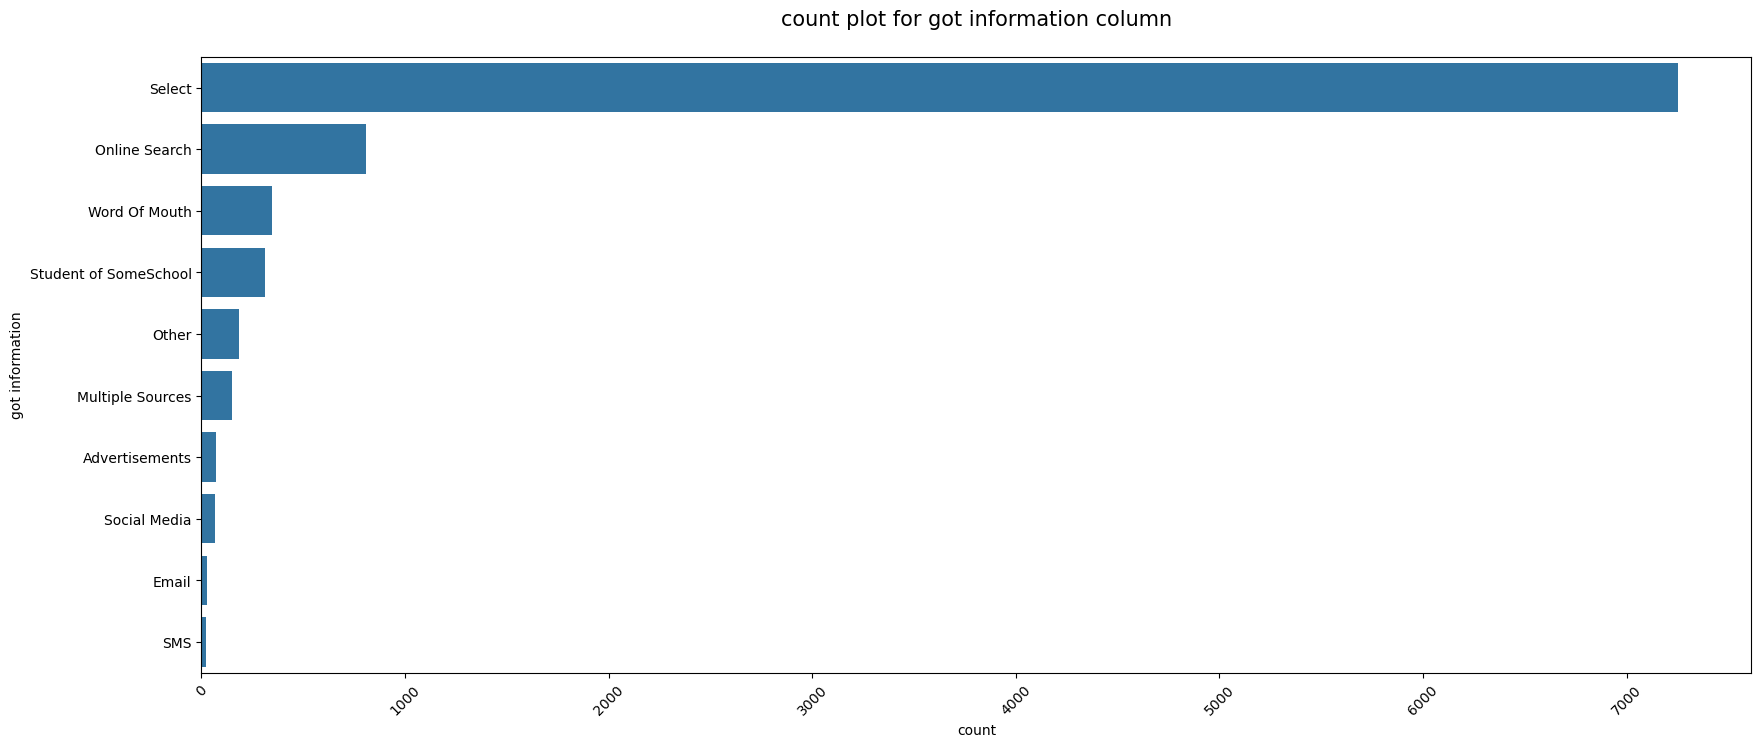


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Occupation column:

Occupation
Unemployed              0.897186
Working Professional    0.076407
Student                 0.022727
Other                   0.001732
Housewife               0.001082
Businessman             0.000866
Name: proportion, dtype: float64
..................................................

mode of Occupation column: Unemployed

..................................................


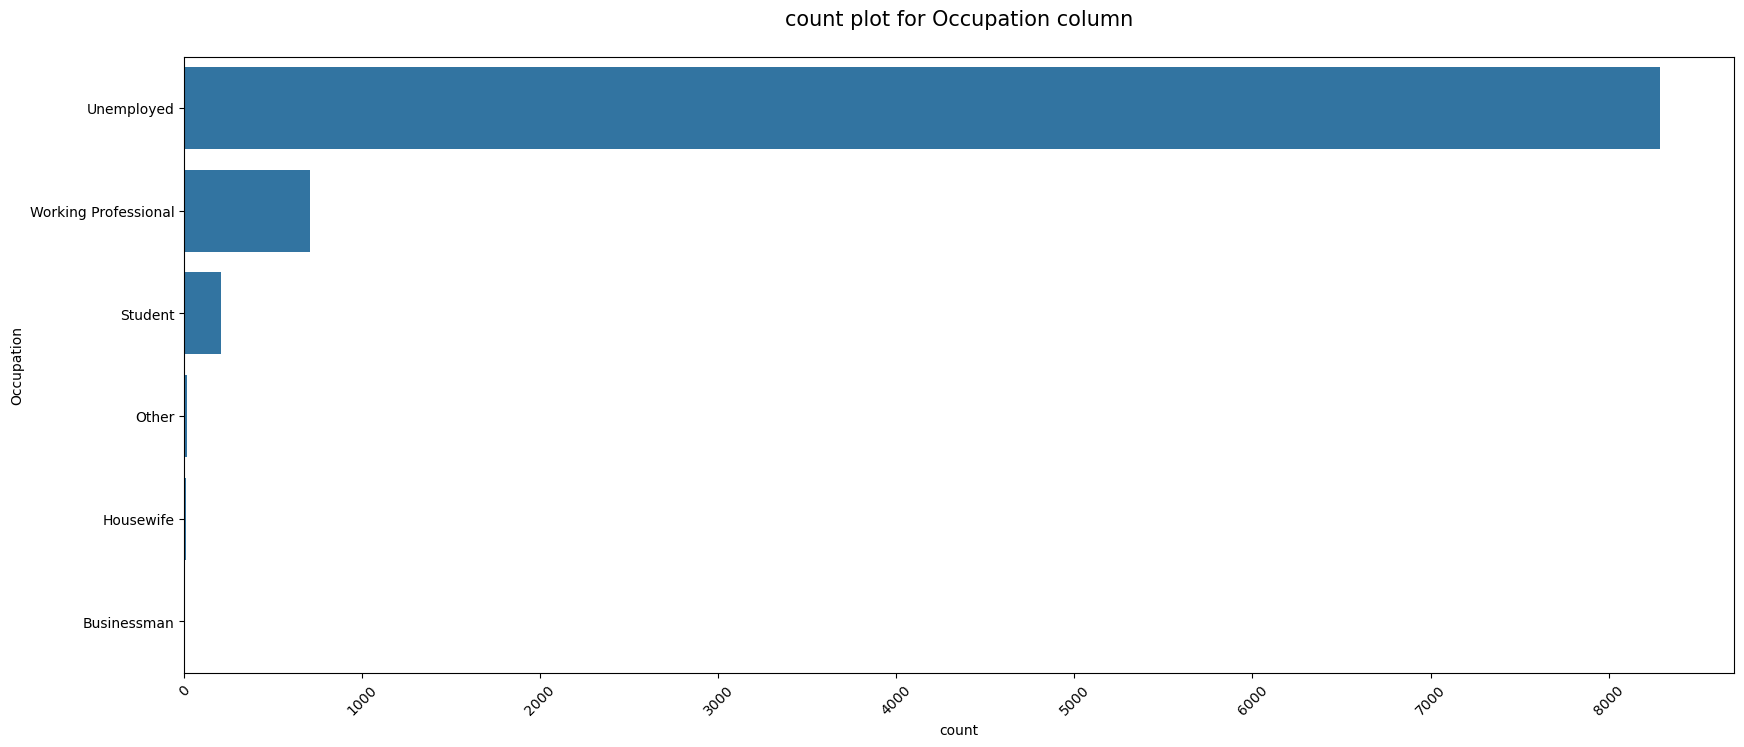


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Reason_for_Choosing column:

Reason_for_Choosing
Better Career Prospects      0.999675
Flexibility & Convenience    0.000216
Other                        0.000108
Name: proportion, dtype: float64
..................................................

mode of Reason_for_Choosing column: Better Career Prospects

..................................................


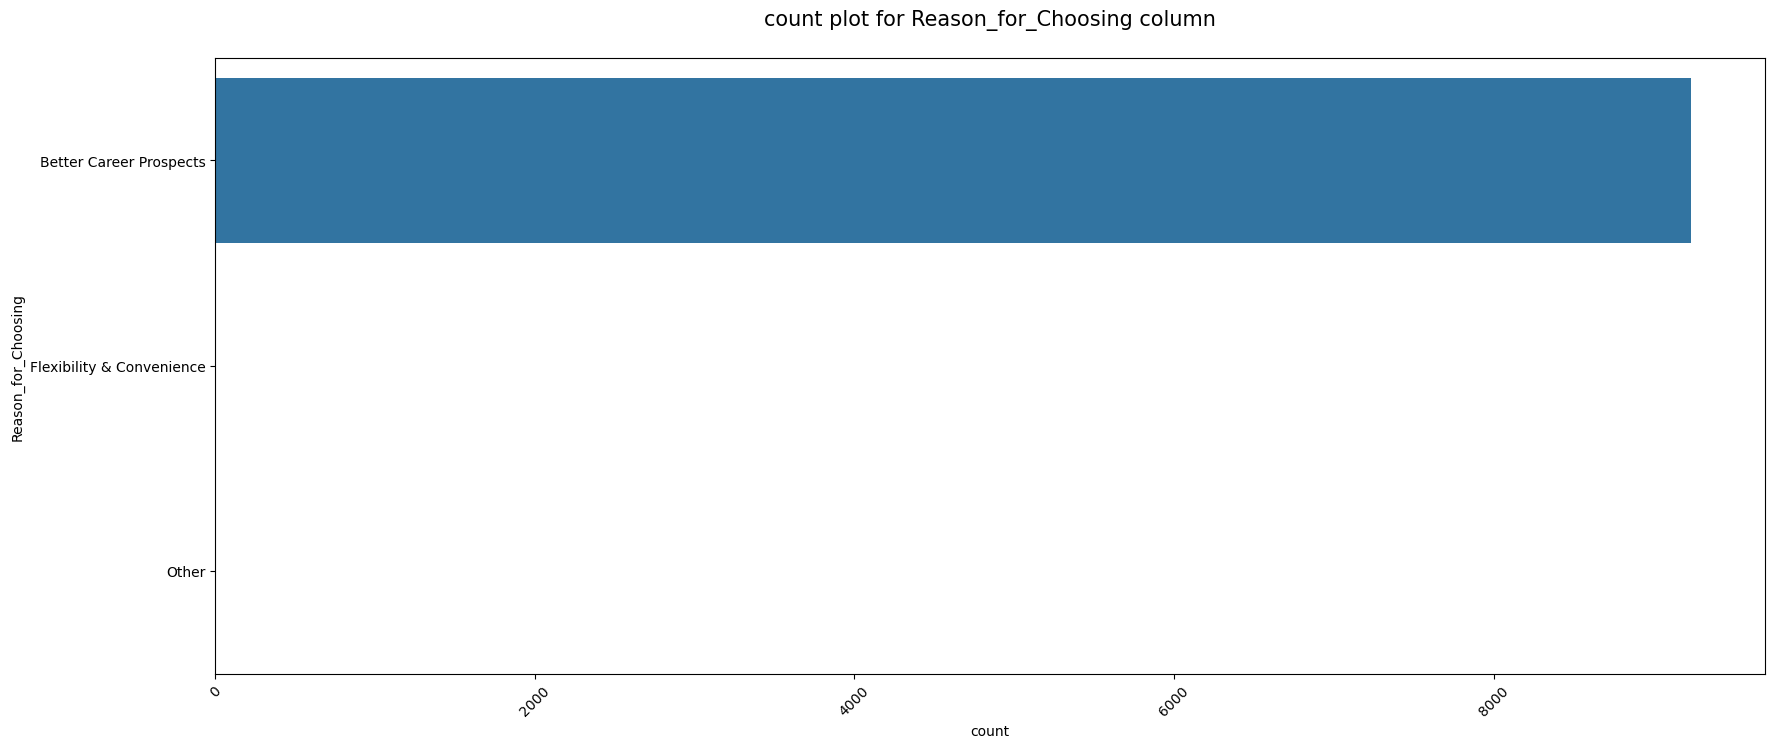


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Search column:

Search
No     0.998485
Yes    0.001515
Name: proportion, dtype: float64
..................................................

mode of Search column: No

..................................................


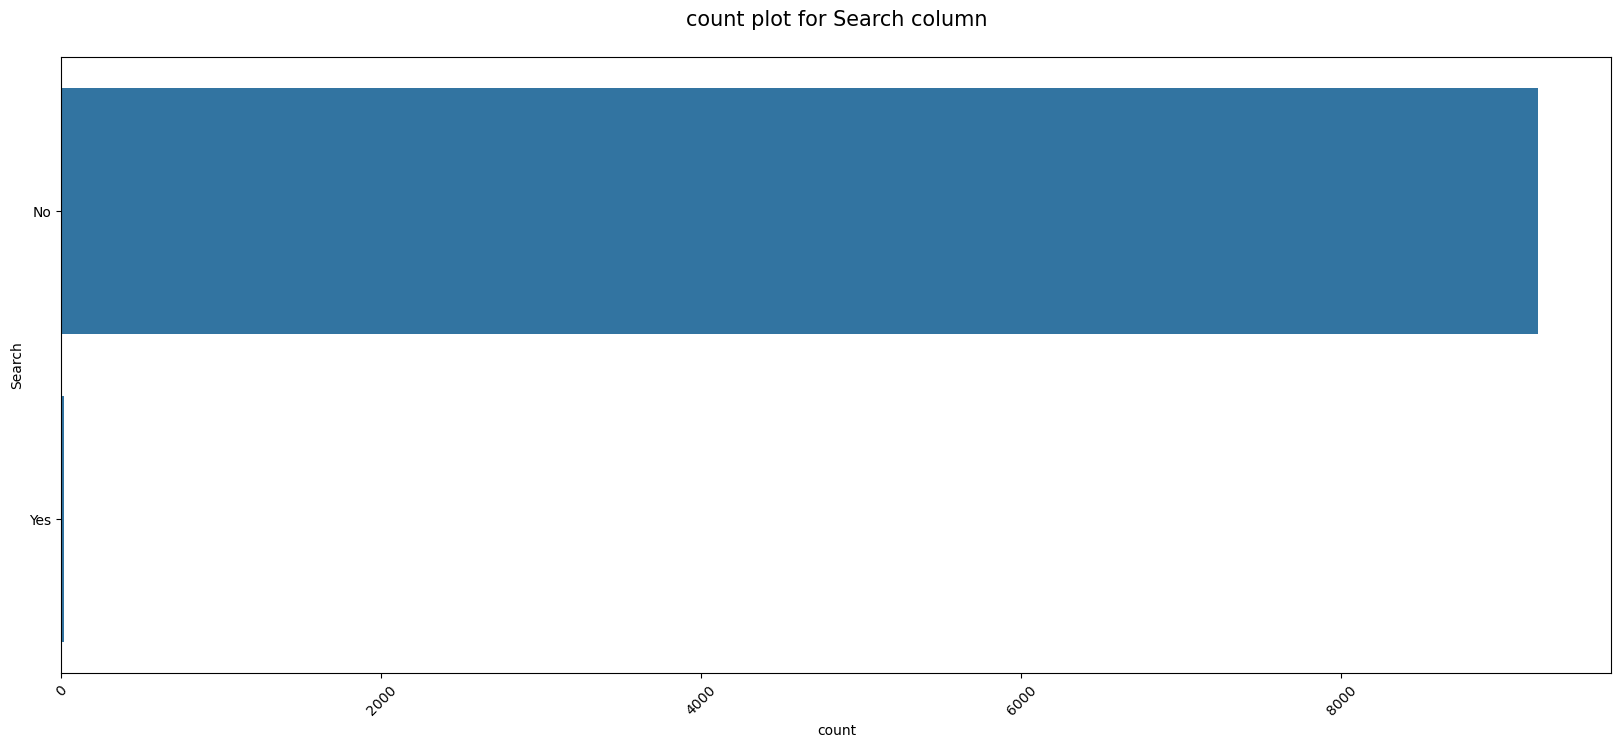


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Magazine column:

Magazine
No    1.0
Name: proportion, dtype: float64
..................................................

mode of Magazine column: No

..................................................


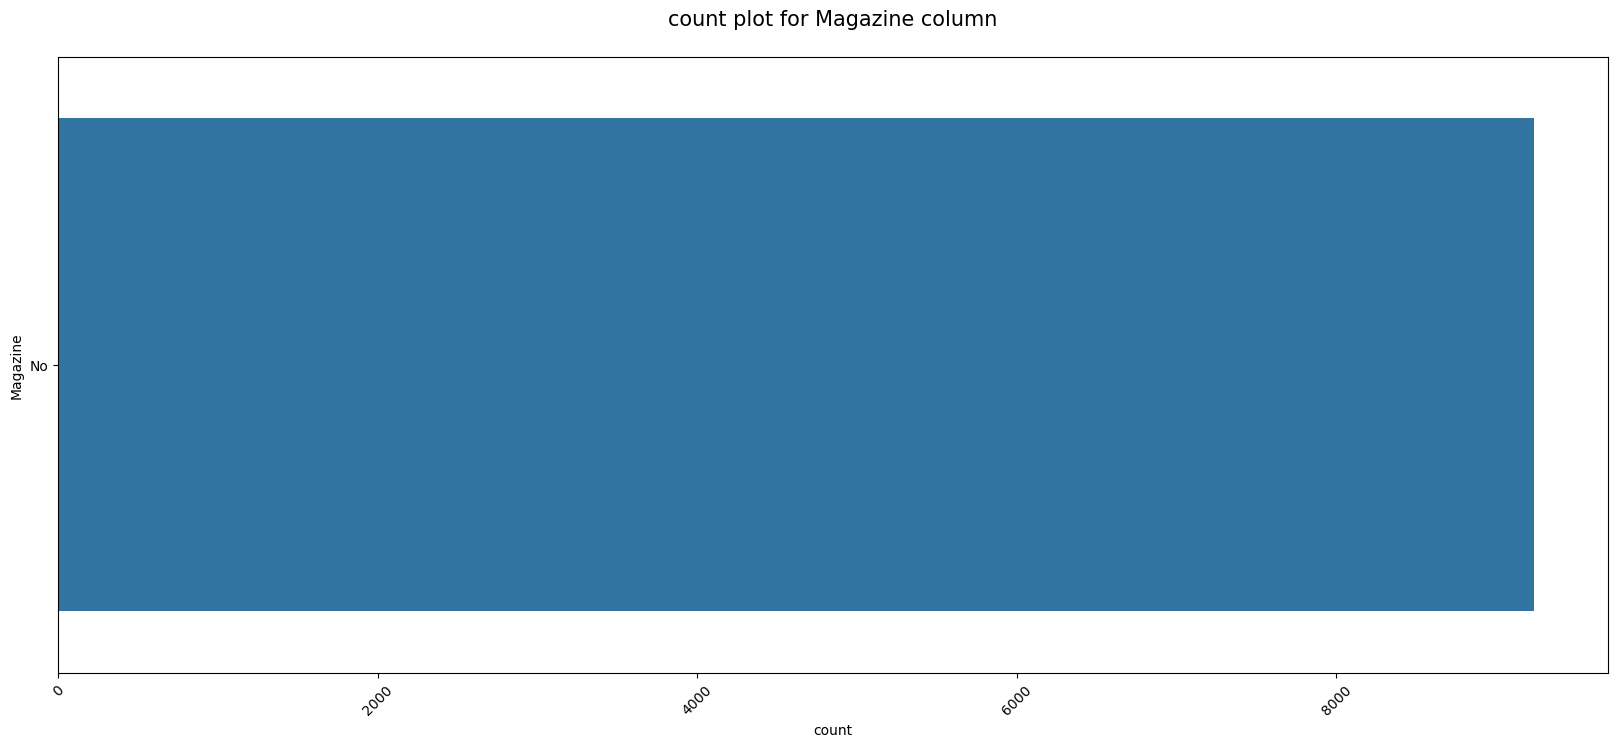


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for News_article column:

News_article
No     0.999784
Yes    0.000216
Name: proportion, dtype: float64
..................................................

mode of News_article column: No

..................................................


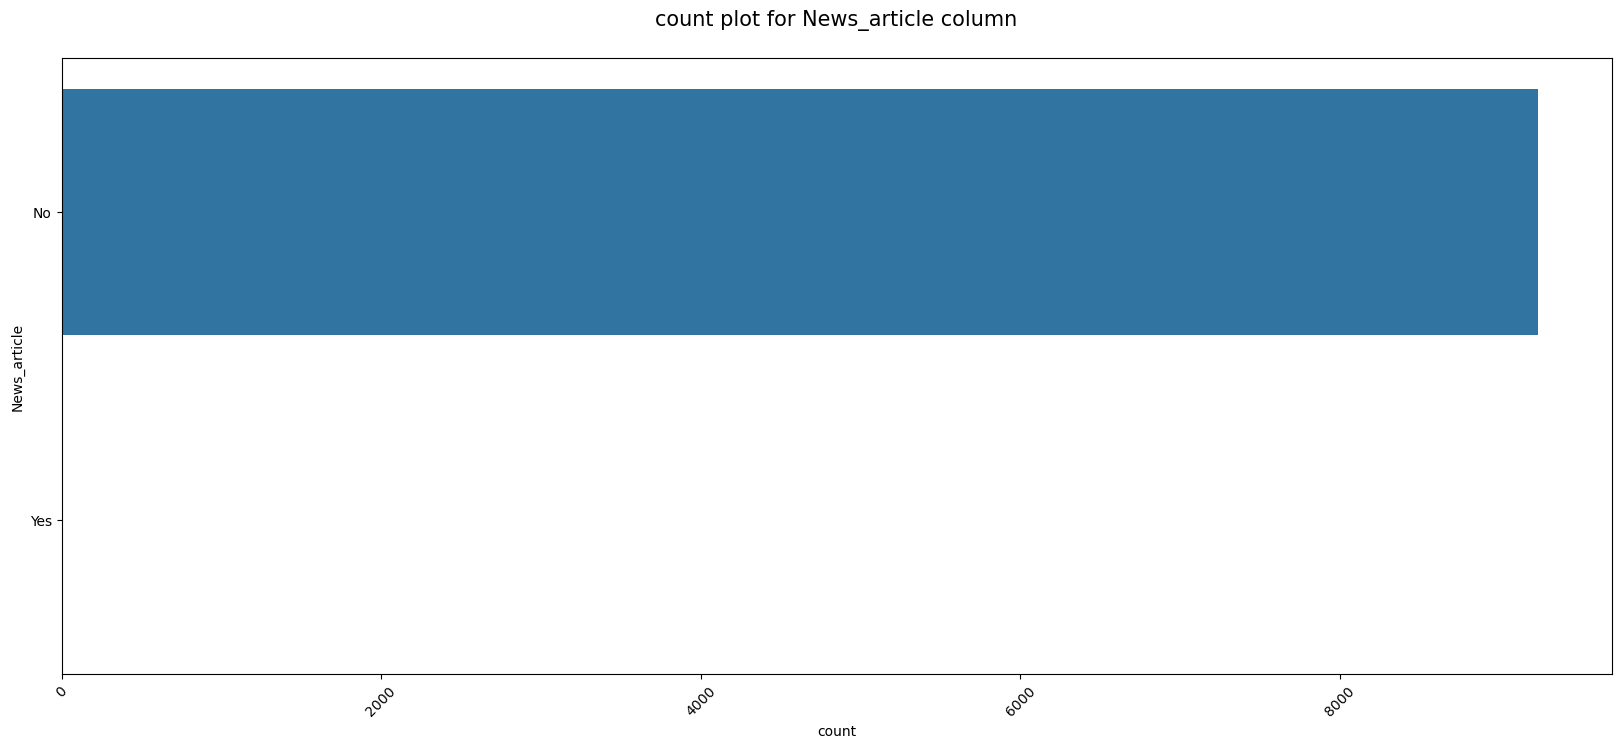


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Forums column:

Forums
No     0.999892
Yes    0.000108
Name: proportion, dtype: float64
..................................................

mode of Forums column: No

..................................................


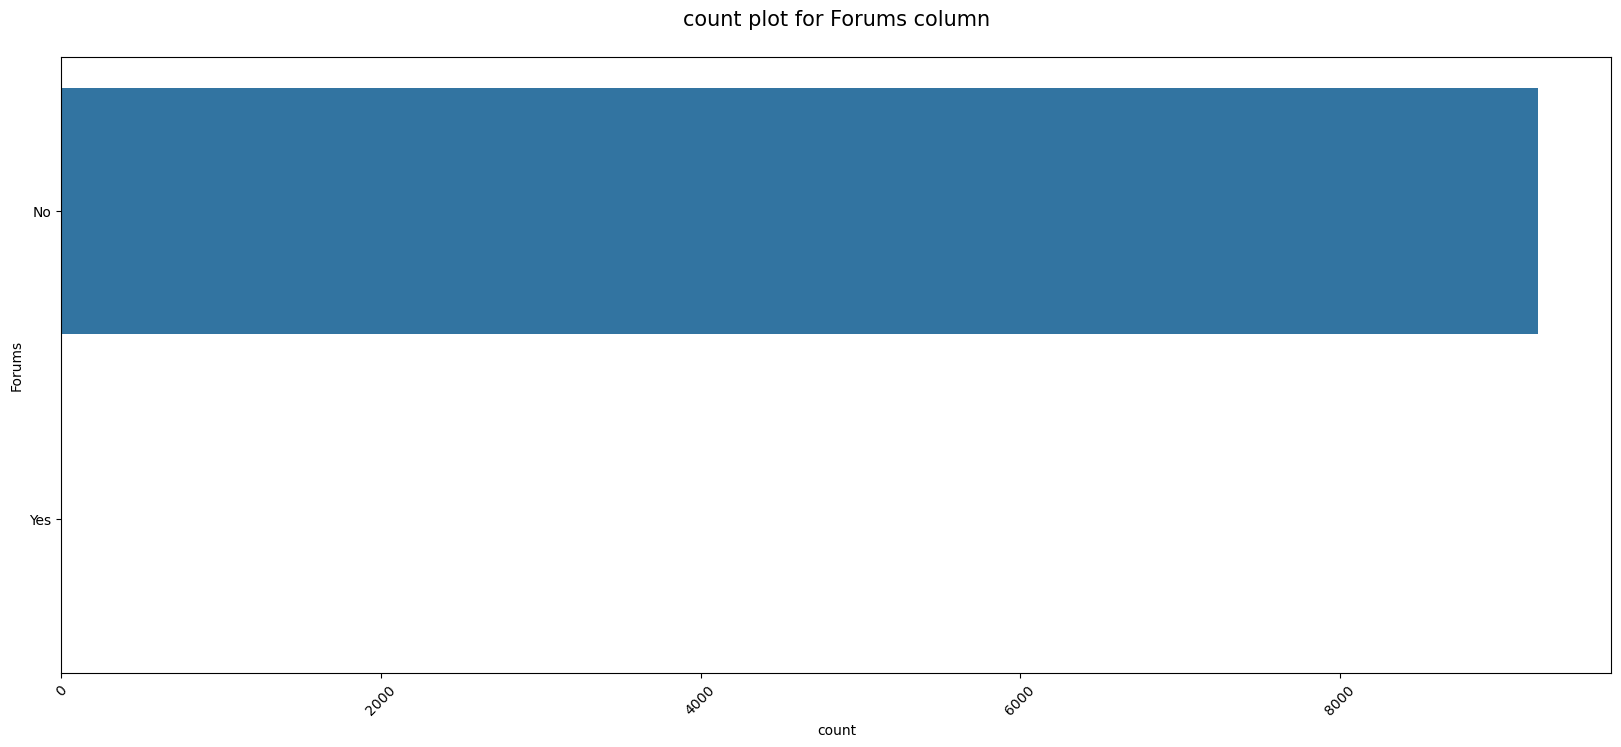


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Newspaper column:

Newspaper
No     0.999892
Yes    0.000108
Name: proportion, dtype: float64
..................................................

mode of Newspaper column: No

..................................................


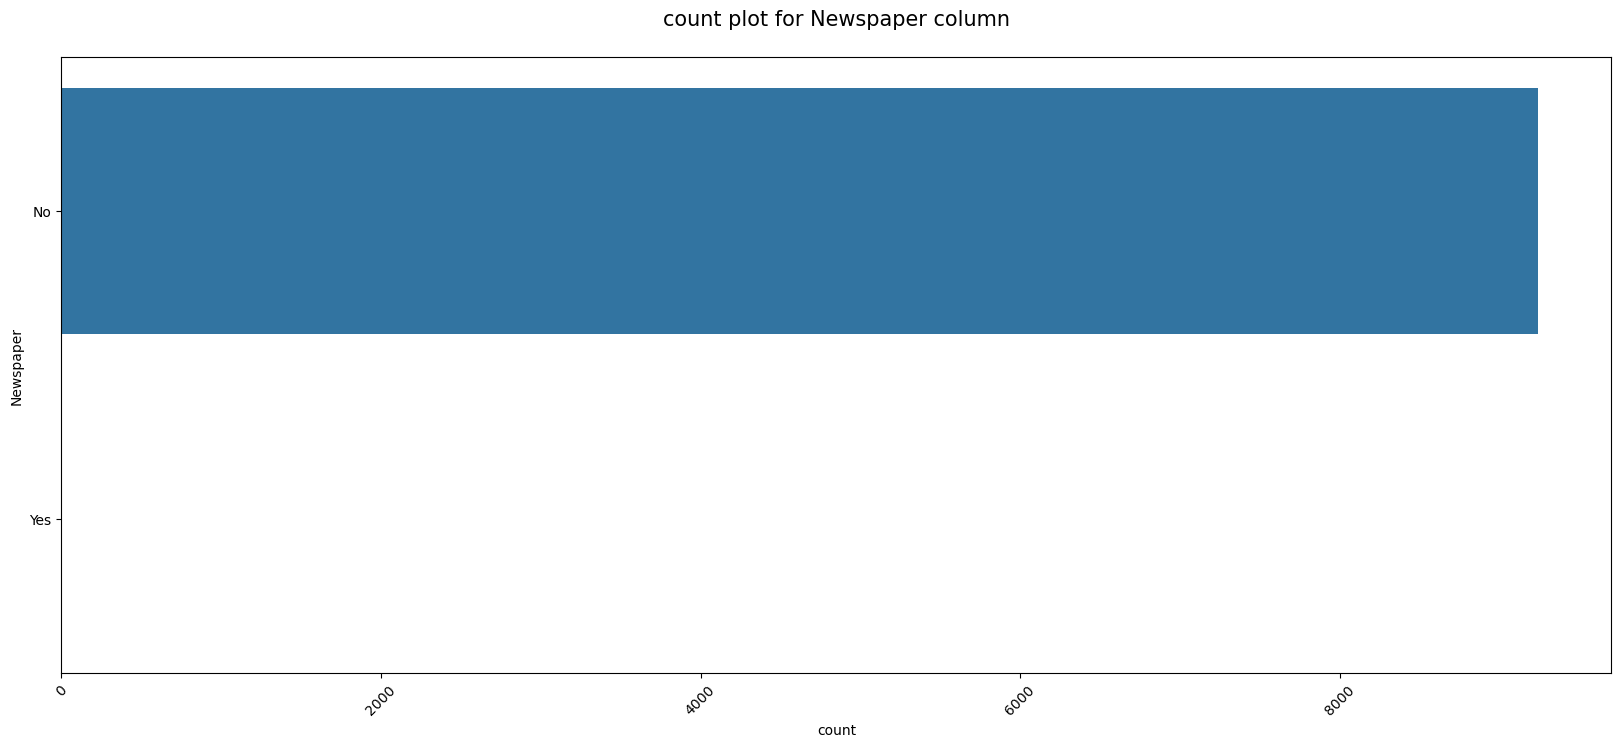


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Ads column:

Ads
No     0.999567
Yes    0.000433
Name: proportion, dtype: float64
..................................................

mode of Ads column: No

..................................................


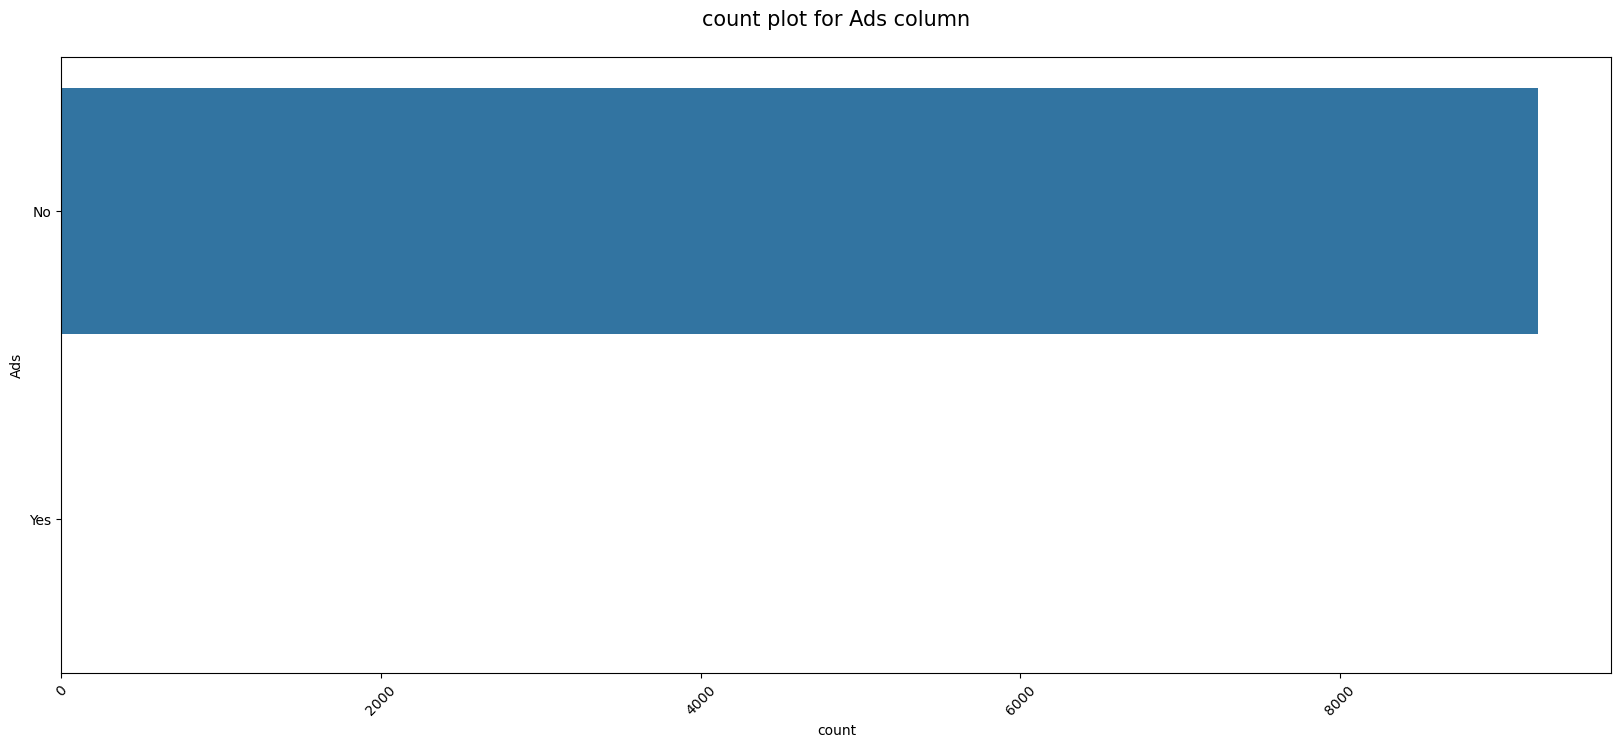


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Recommendation column:

Recommendation
No     0.999242
Yes    0.000758
Name: proportion, dtype: float64
..................................................

mode of Recommendation column: No

..................................................


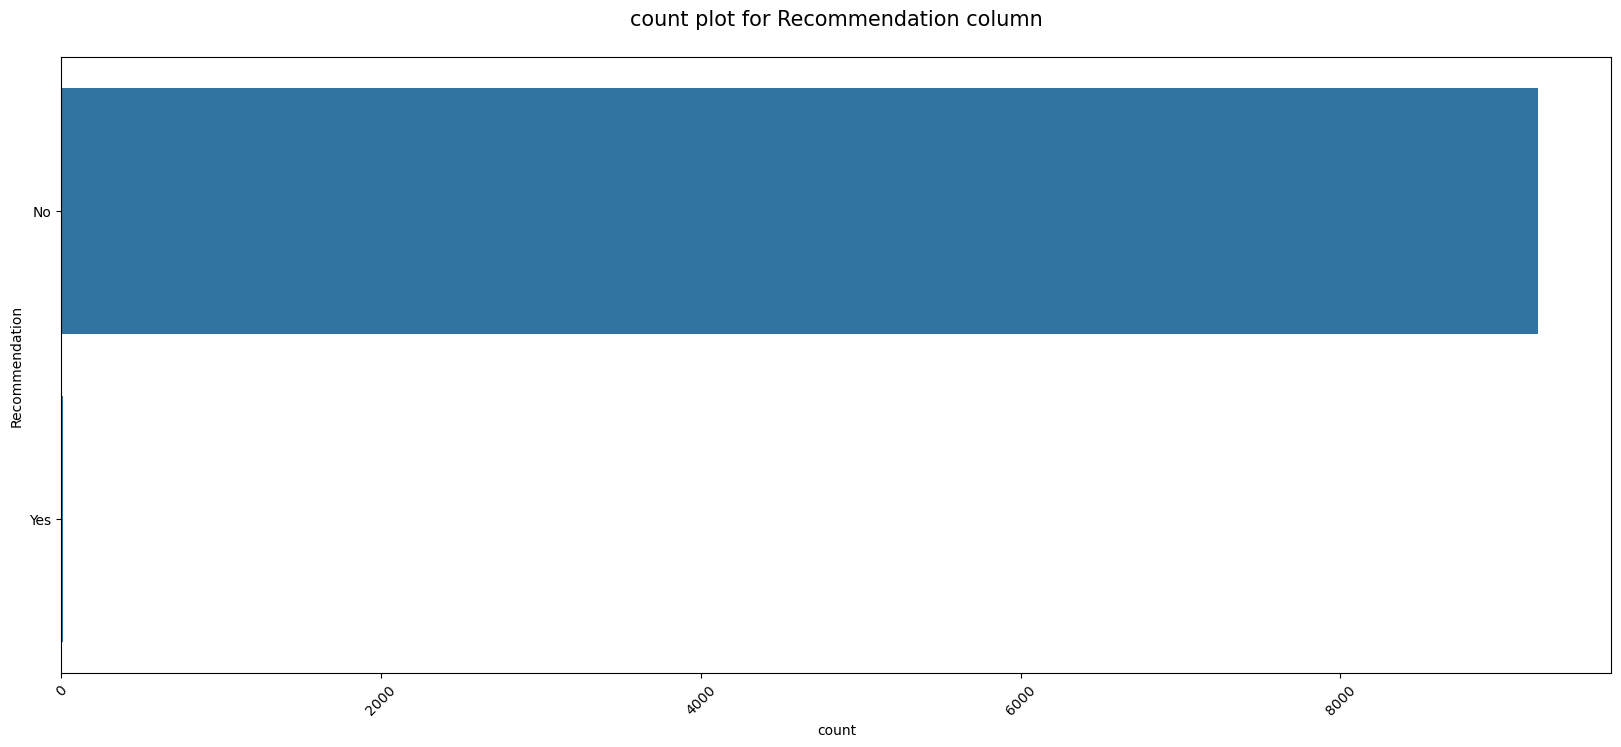


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Course_updates column:

Course_updates
No    1.0
Name: proportion, dtype: float64
..................................................

mode of Course_updates column: No

..................................................


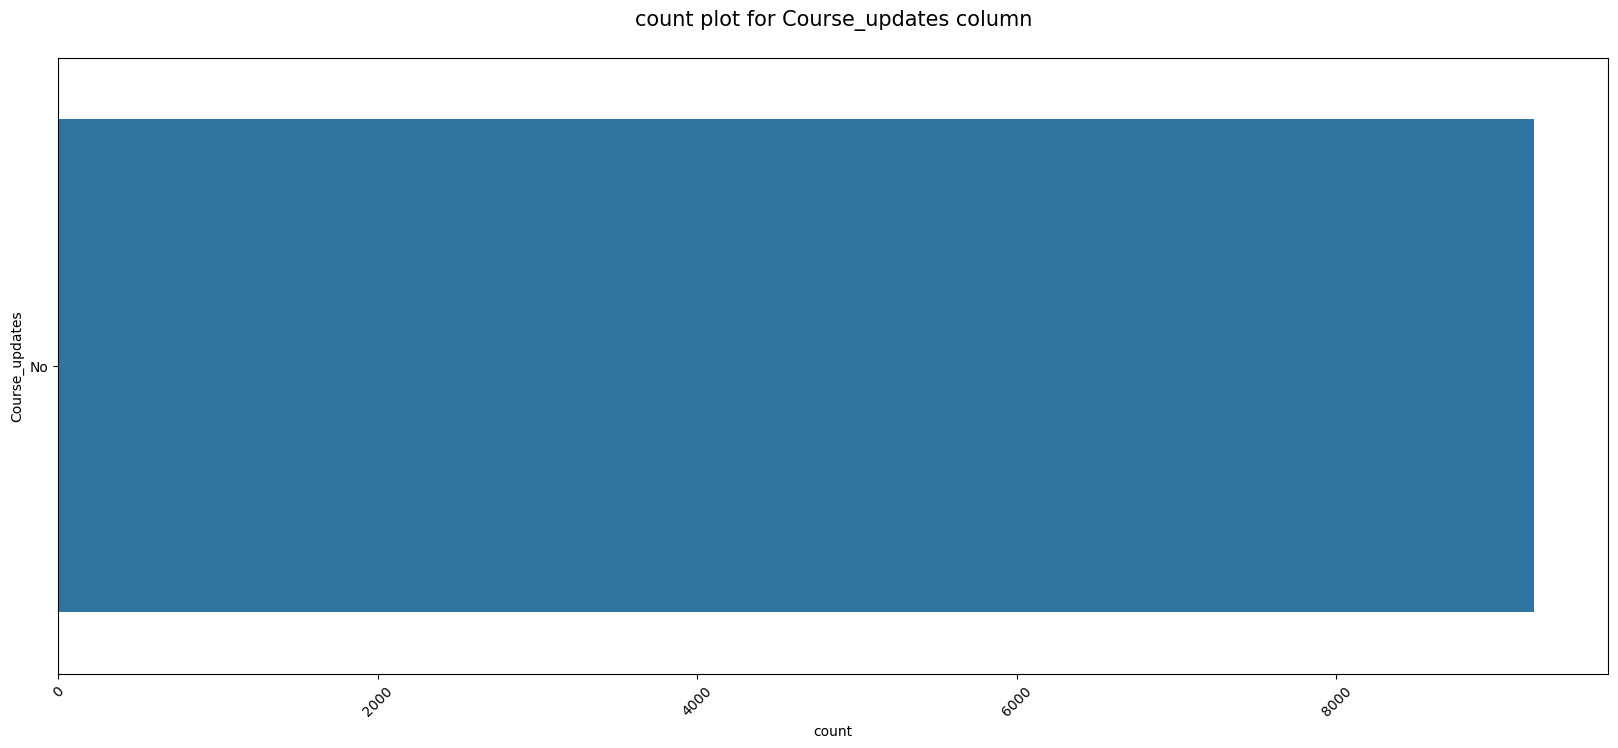


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Tags column:

Tags
Will revert after reading the email                  0.587121
Ringing                                              0.130195
Interested in other courses                          0.055519
Already a student                                    0.050325
Closed by Horizzon                                   0.038745
switched off                                         0.025974
Busy                                                 0.020130
Lost to EINS                                         0.018939
Not doing further education                          0.015693
Interested  in full time MBA                         0.012662
Graduation in progress                               0.012013
invalid number                                       0.008983
Diploma holder (Not Eligible)                        0.006818
wrong number given                                   0.005087
opp hangup                        

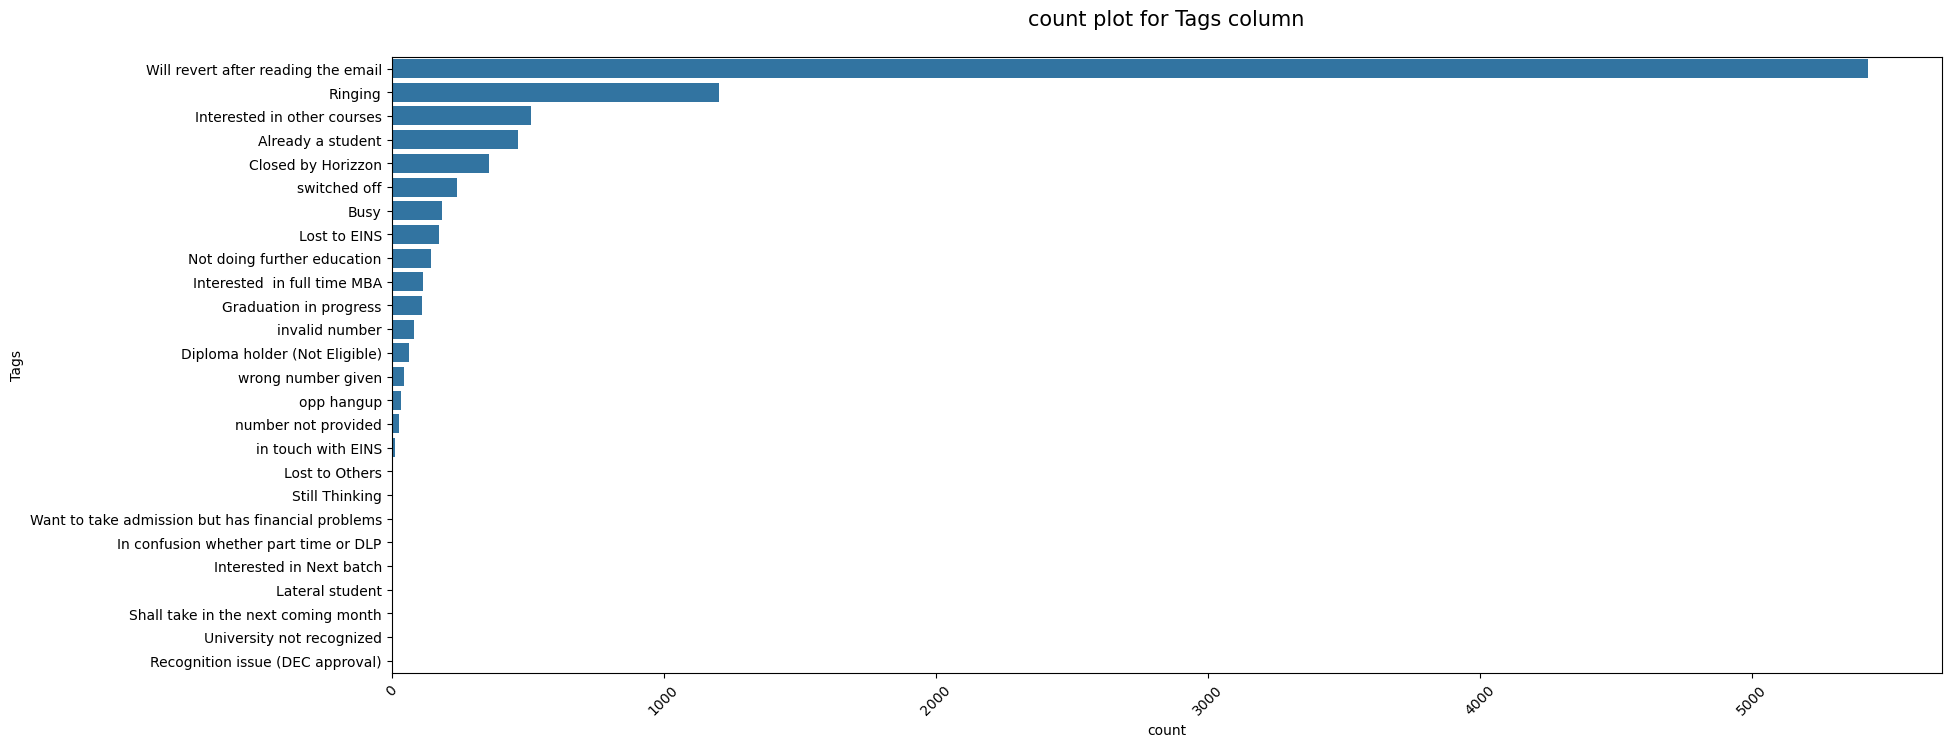


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Content_updates column:

Content_updates
No    1.0
Name: proportion, dtype: float64
..................................................

mode of Content_updates column: No

..................................................


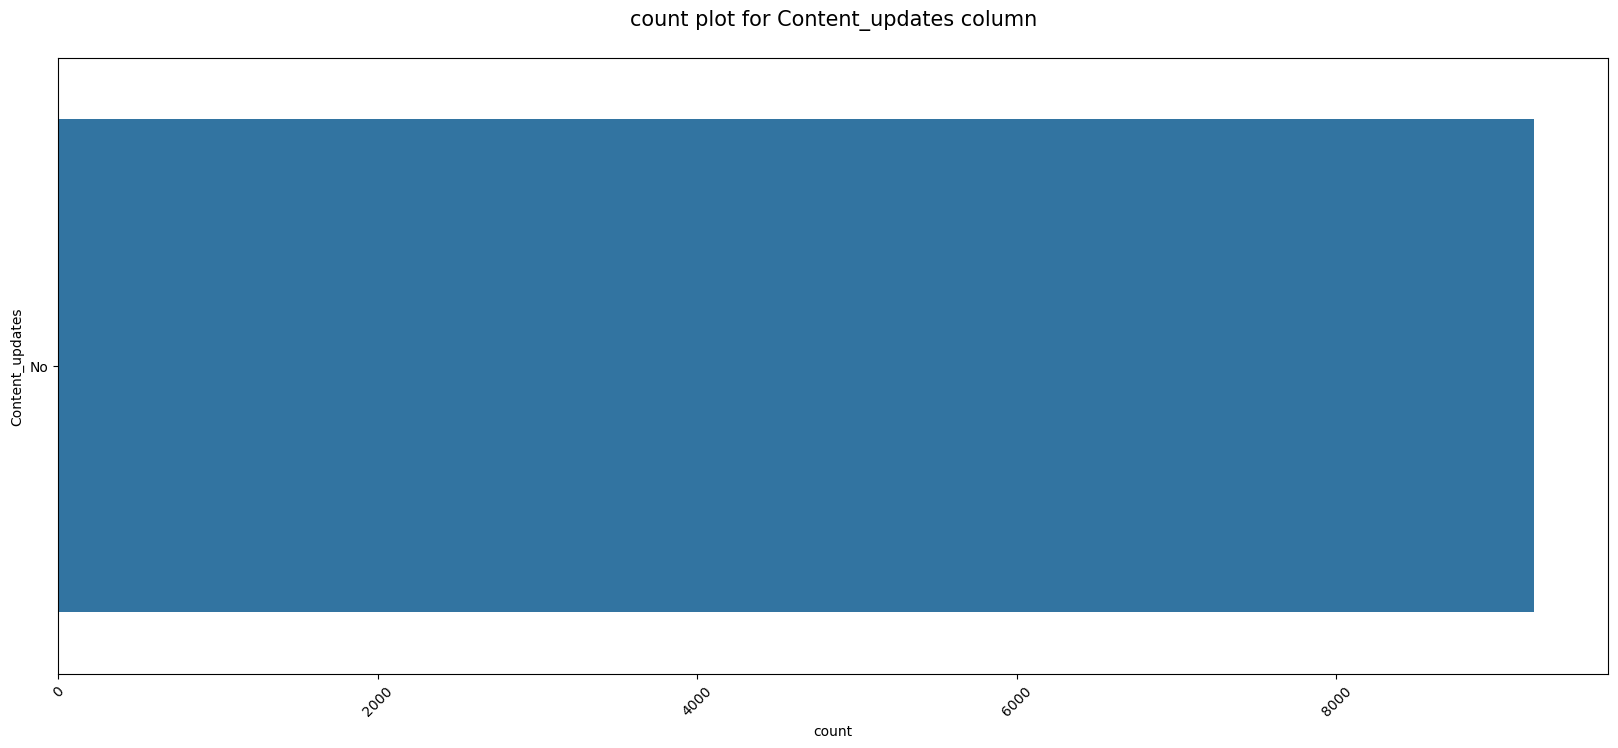


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Lead Profile column:

Lead Profile
Select                         0.741883
Potential Lead                 0.174567
Other Leads                    0.052706
Student of SomeSchool          0.026082
Lateral Student                0.002597
Dual Specialization Student    0.002165
Name: proportion, dtype: float64
..................................................

mode of Lead Profile column: Select

..................................................


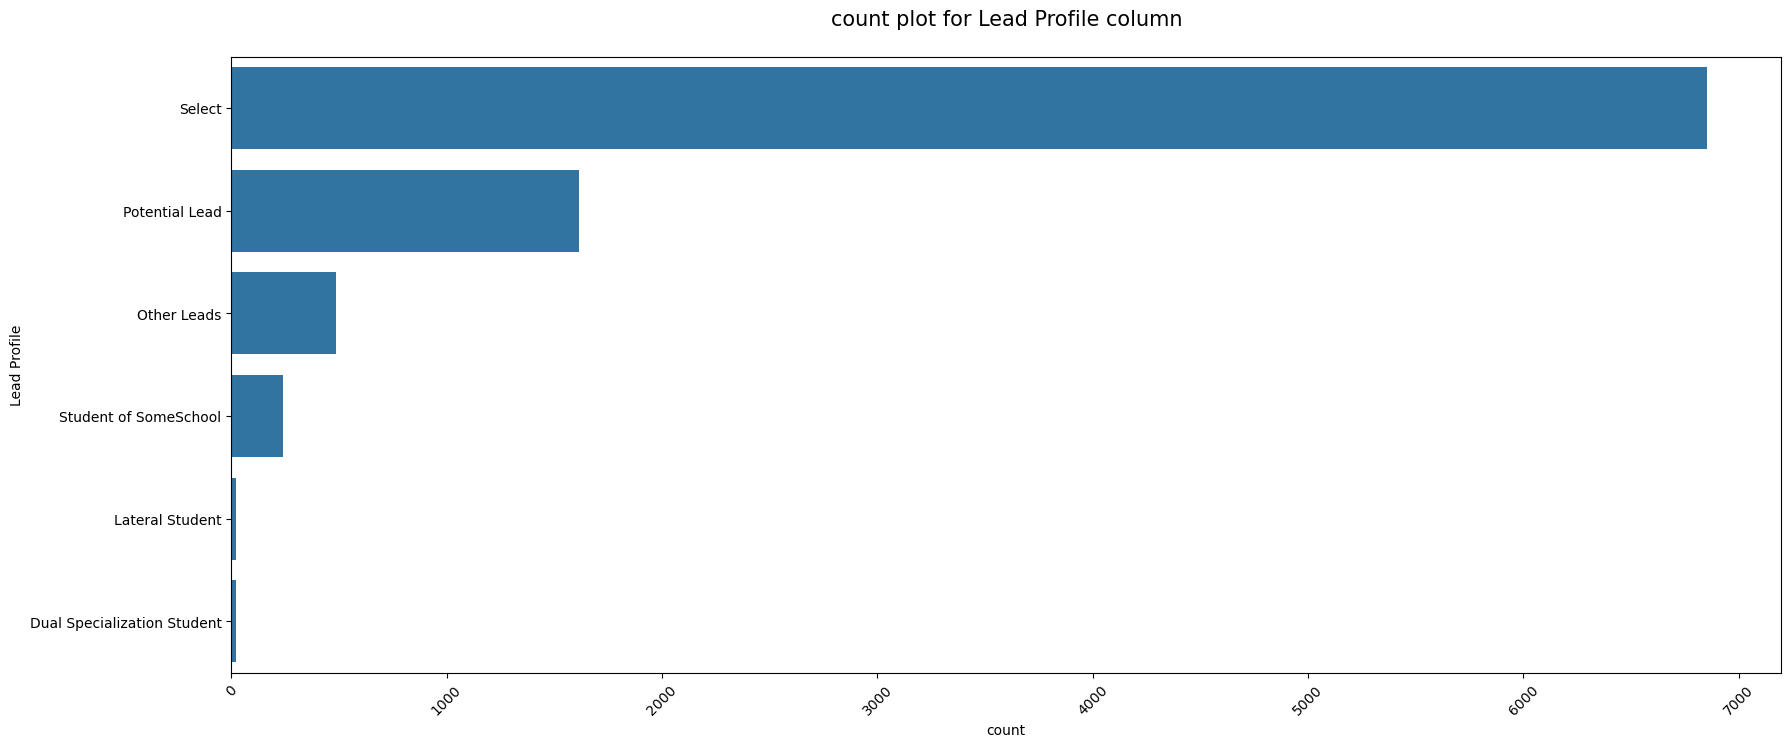


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for City column:

City
Mumbai                         0.502381
Select                         0.243398
Thane & Outskirts              0.081385
Other Cities                   0.074242
Other Cities of Maharashtra    0.049459
Other Metro Cities             0.041126
Tier II Cities                 0.008009
Name: proportion, dtype: float64
..................................................

mode of City column: Mumbai

..................................................


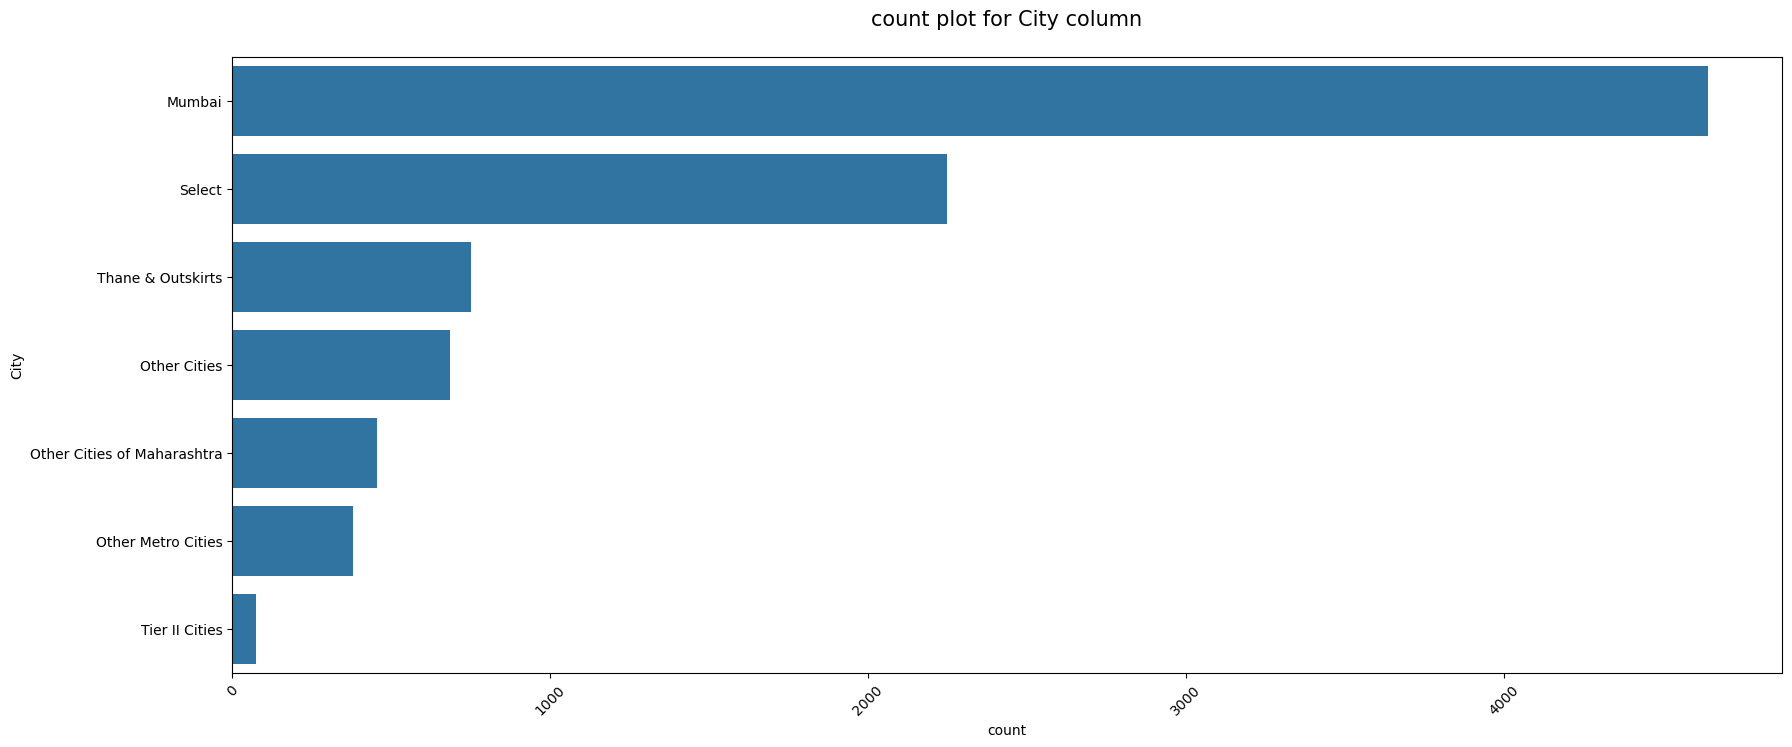


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Pay_cheque column:

Pay_cheque
No    1.0
Name: proportion, dtype: float64
..................................................

mode of Pay_cheque column: No

..................................................


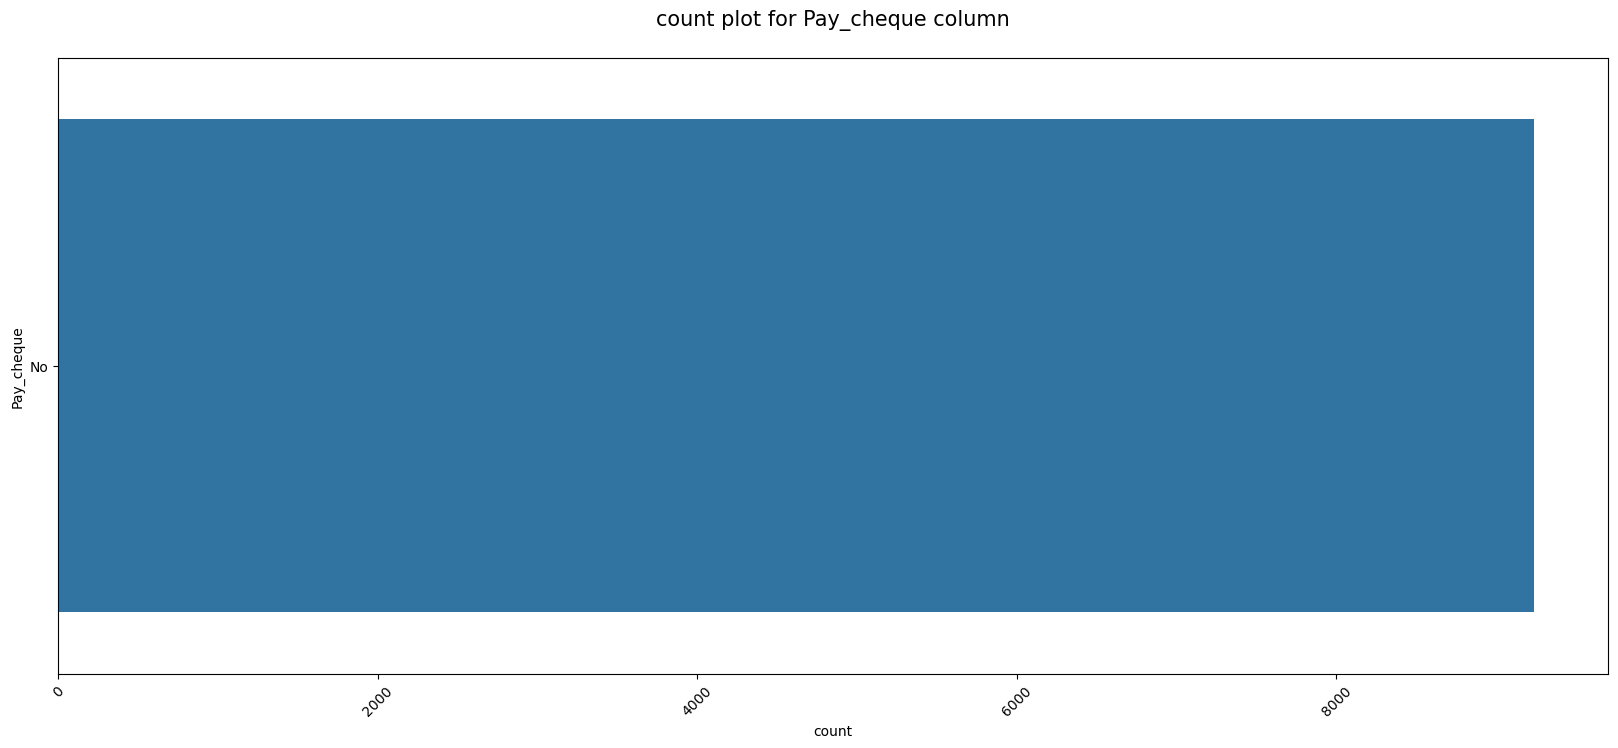


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Free_copy column:

Free_copy
No     0.687446
Yes    0.312554
Name: proportion, dtype: float64
..................................................

mode of Free_copy column: No

..................................................


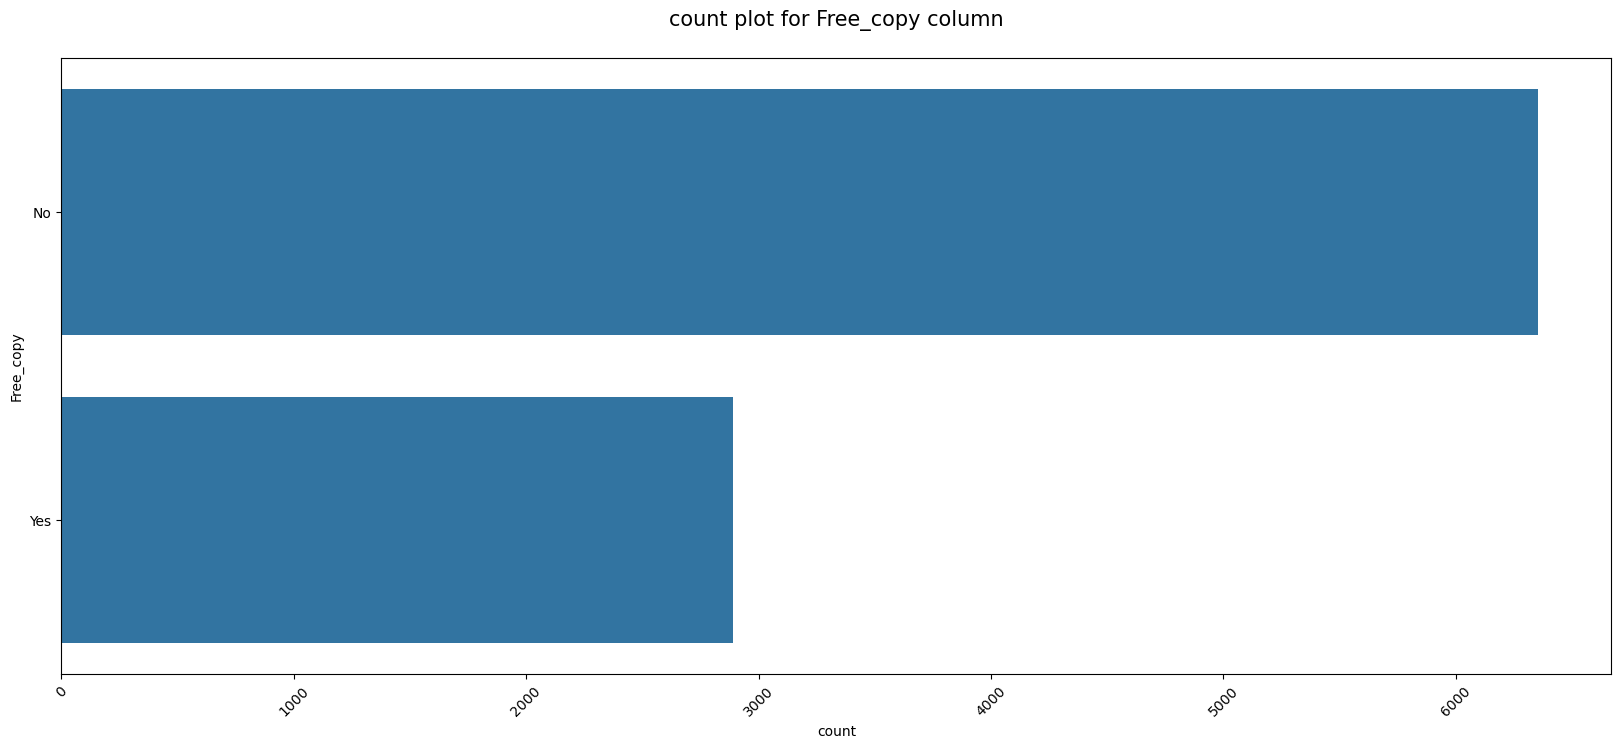


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
value counts for Last_notable_activity column:

Last_notable_activity
Modified                        0.368723
Email Opened                    0.305952
SMS Sent                        0.235065
Page Visited on Website         0.034416
Olark Chat Conversation         0.019805
Email Link Clicked              0.018723
Email Bounced                   0.006494
Unsubscribed                    0.005087
Unreachable                     0.003463
Had a Phone Conversation        0.001515
Email Marked Spam               0.000216
Approached upfront              0.000108
Resubscribed to emails          0.000108
View in browser link Clicked    0.000108
Form Submitted on Website       0.000108
Email Received                  0.000108
Name: proportion, dtype: float64
..................................................

mode of Last_notable_activity column: Modified

..................................................


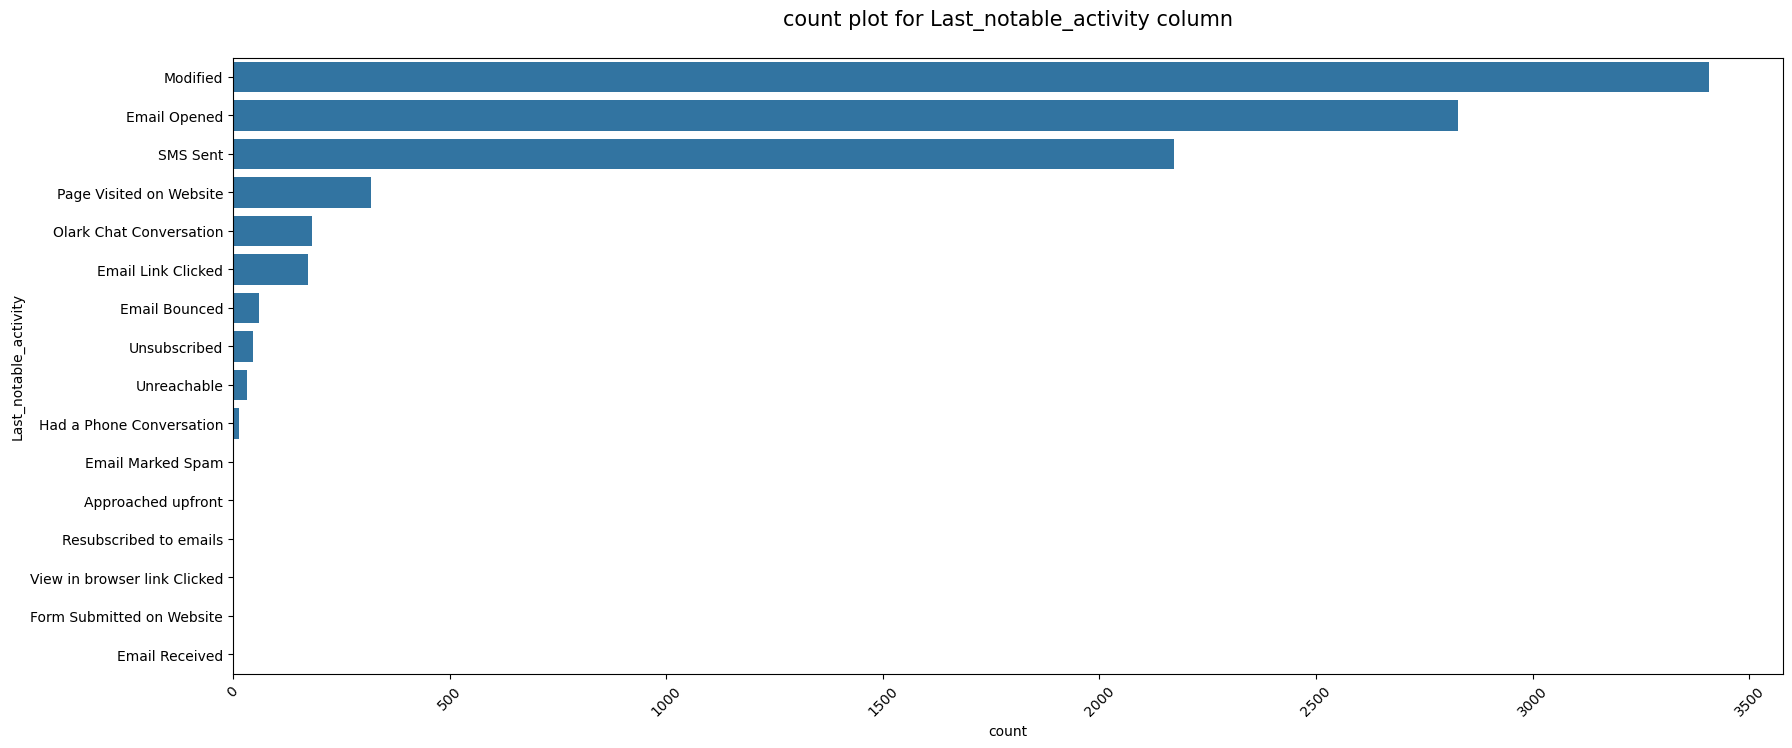


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [402]:
# getting insights from caegoical variable 

for col in lead_score.columns:
    if lead_score[col].dtype == 'object':
        print('value counts for {} column:'.format(col))
        print()
        print(lead_score[col].value_counts(normalize = True).sort_values(ascending = False))
        print('.'*50)
        print()
        print('mode of {} column:'.format(col),lead_score[col].mode()[0])
        print()
        print('.'*50)
        plt.figure(figsize = [20,8])
        sns.countplot(lead_score[col], order = lead_score[col].value_counts().index)
        #sns.countplot(titanic, x="class", hue="survived")
        plt.xticks(rotation = 45)
        plt.title('count plot for {} column\n'.format(col),fontdict = {'color':'k','fontsize': 15})
        plt.show()
        print()
        print('X'*60)

## inferences 

* Lead origin
1. Maximum leads are originated from Landing Page Submission and API
2. Conversion rate is also high from these
* Lead Source
1. Maximum leads are sourced from Google and Direct Traffic
2. Conversion rate is also high for these
3.Most of the leads have opted for email and phone call commnications
* Country
  ~96% of leads are from India
* Specialization
1. Most of the leads have Finance and Human Resource Management specialization
* Occupation
1. 85% of leads are unemployed with high conversion rate
* Reason_for_Choosing
1. ~99% of leads are choosing the plaform for better career prospects
* City
1. Most of the leads are from Mumbai with high conversion rate


### univariate - numerical analysis 

statistical summary of 'Lead_Number' column:

count      9240.000000
mean     617188.435606
std       23405.995698
min      579533.000000
25%      596484.500000
50%      615479.000000
75%      637387.250000
max      660737.000000
Name: Lead_Number, dtype: float64
..................................................
minimum value of 'Lead_Number' column: 579533

maximum value of 'Lead_Number' column: 660737

..................................................
distribution plot for 'Lead_Number' column



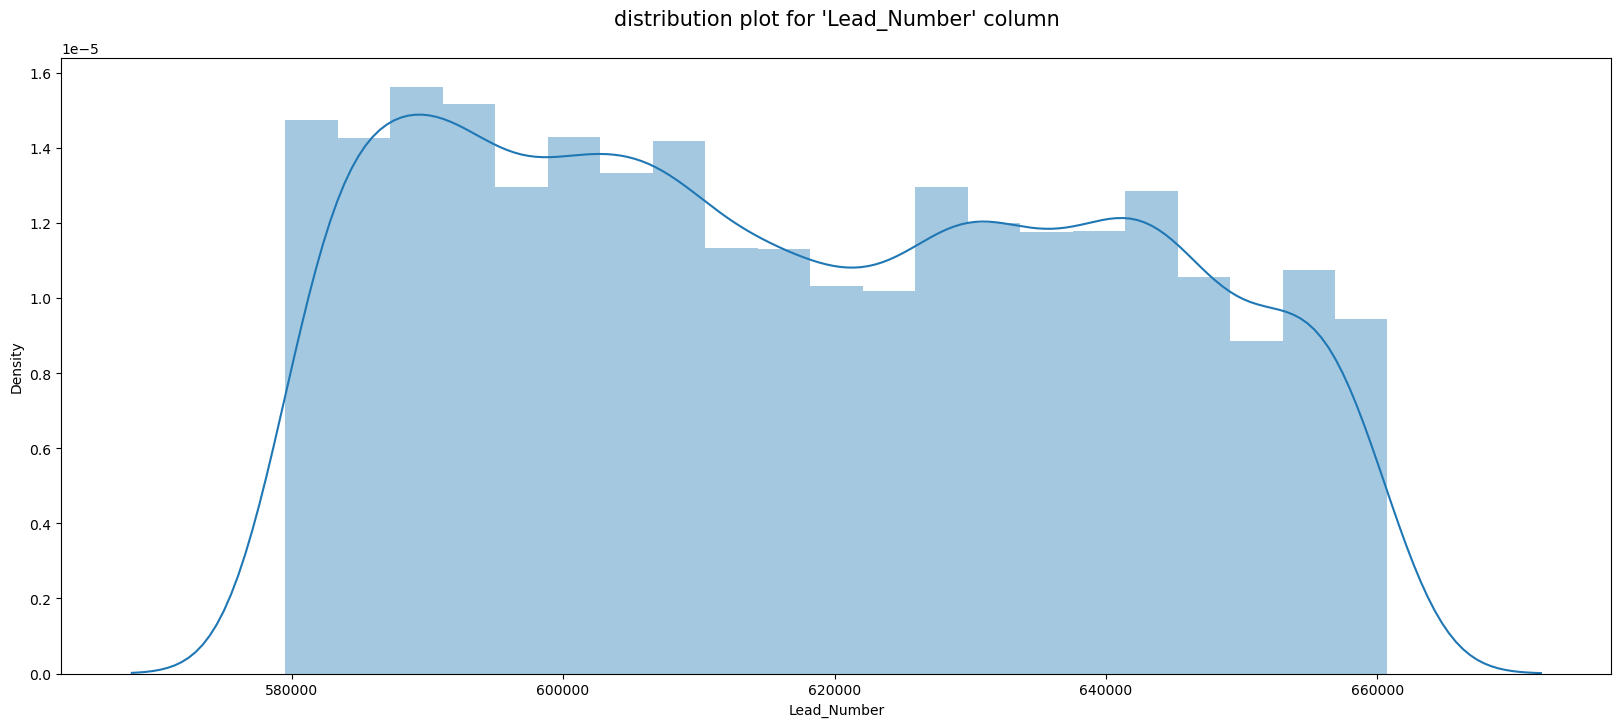


..................................................
distribution plot for 'Lead_Number' column



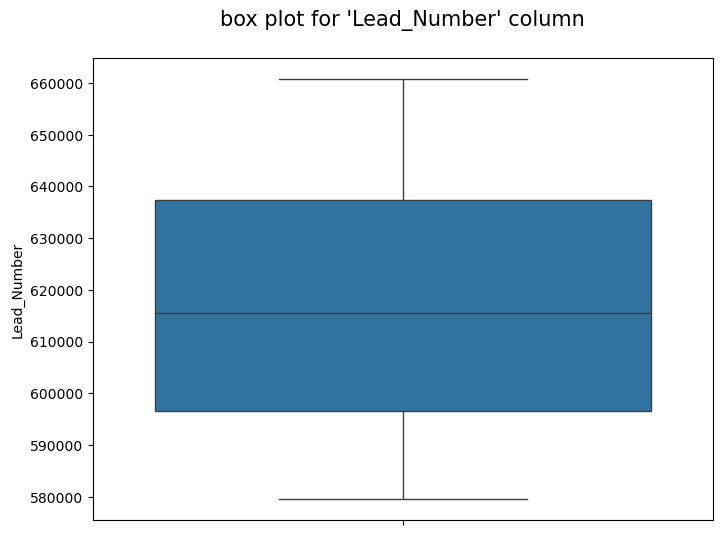


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
statistical summary of 'Converted' column:

count    9240.000000
mean        0.385390
std         0.486714
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Converted, dtype: float64
..................................................
minimum value of 'Converted' column: 0

maximum value of 'Converted' column: 1

..................................................
distribution plot for 'Converted' column



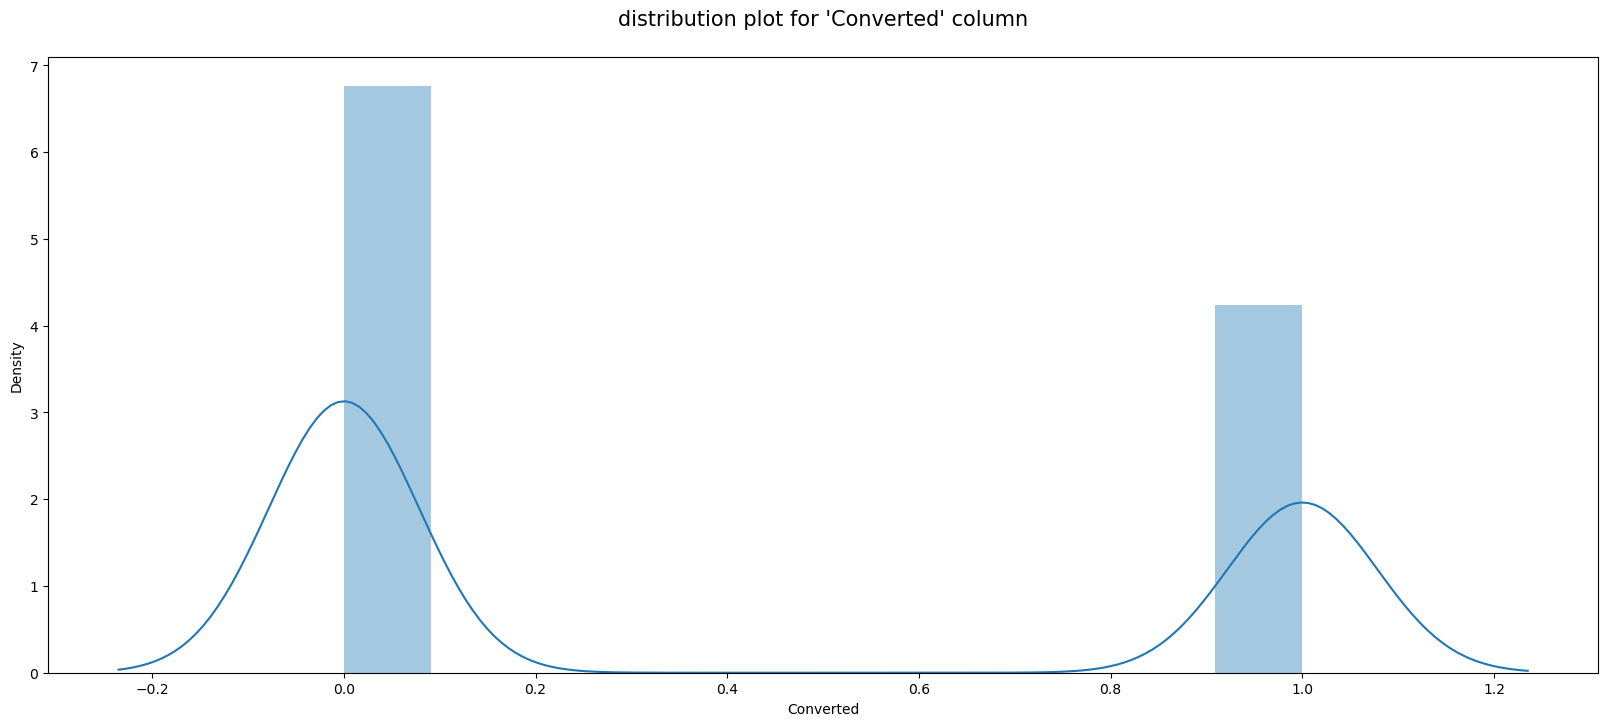


..................................................
distribution plot for 'Converted' column



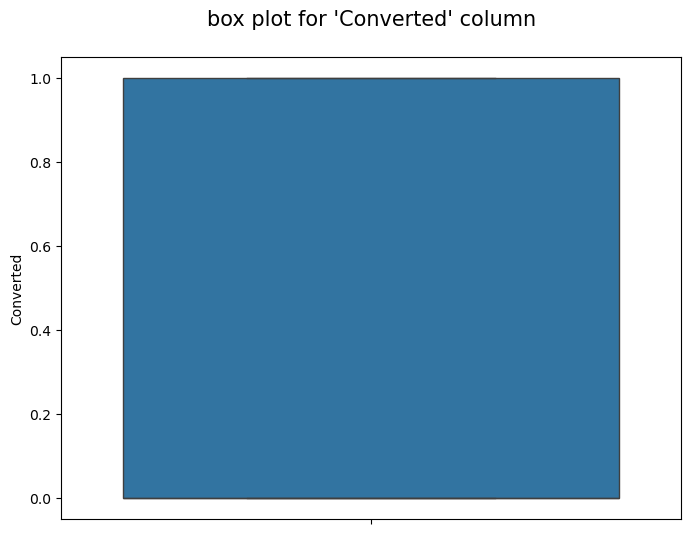


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
statistical summary of 'TotalVisits' column:

count    9240.000000
mean        3.394156
std         4.836682
min         0.000000
25%         0.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64
..................................................
minimum value of 'TotalVisits' column: 0.0

maximum value of 'TotalVisits' column: 251.0

..................................................
distribution plot for 'TotalVisits' column



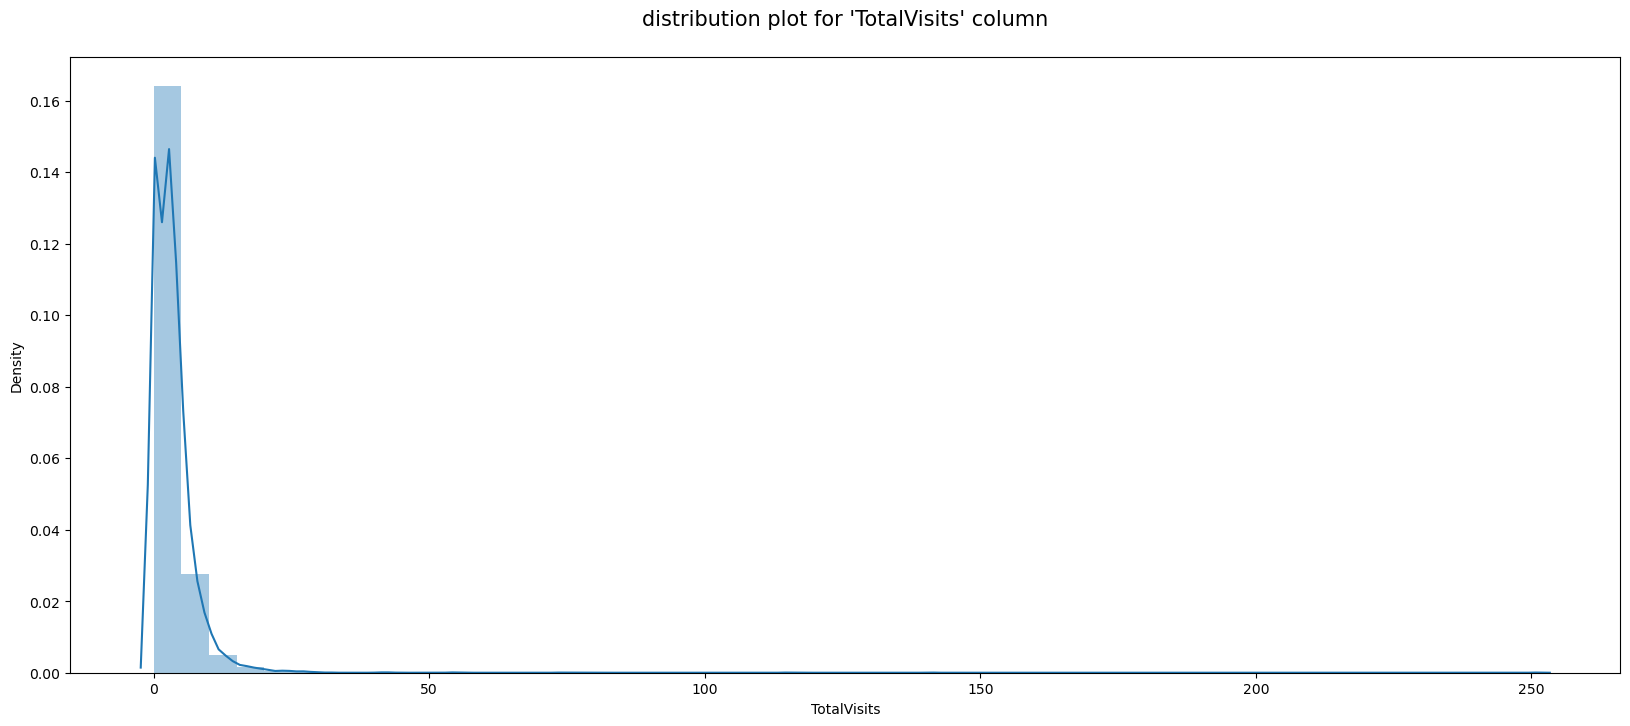


..................................................
distribution plot for 'TotalVisits' column



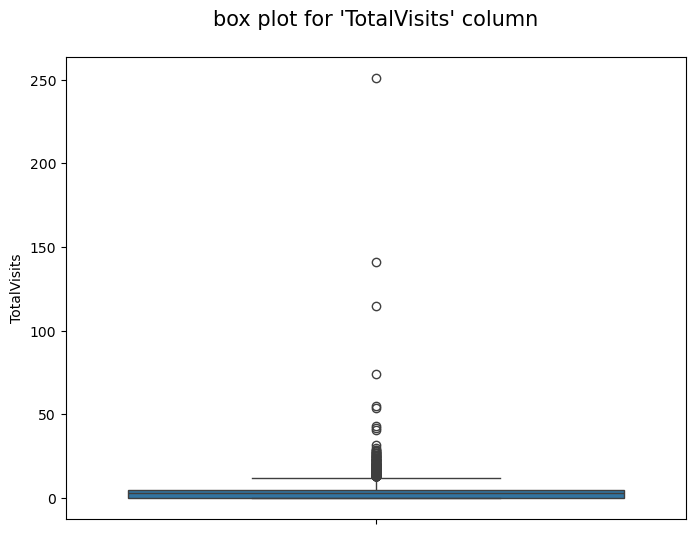


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
statistical summary of 'Time_spent' column:

count    9240.000000
mean      487.698268
std       548.021466
min         0.000000
25%        12.000000
50%       248.000000
75%       936.000000
max      2272.000000
Name: Time_spent, dtype: float64
..................................................
minimum value of 'Time_spent' column: 0

maximum value of 'Time_spent' column: 2272

..................................................
distribution plot for 'Time_spent' column



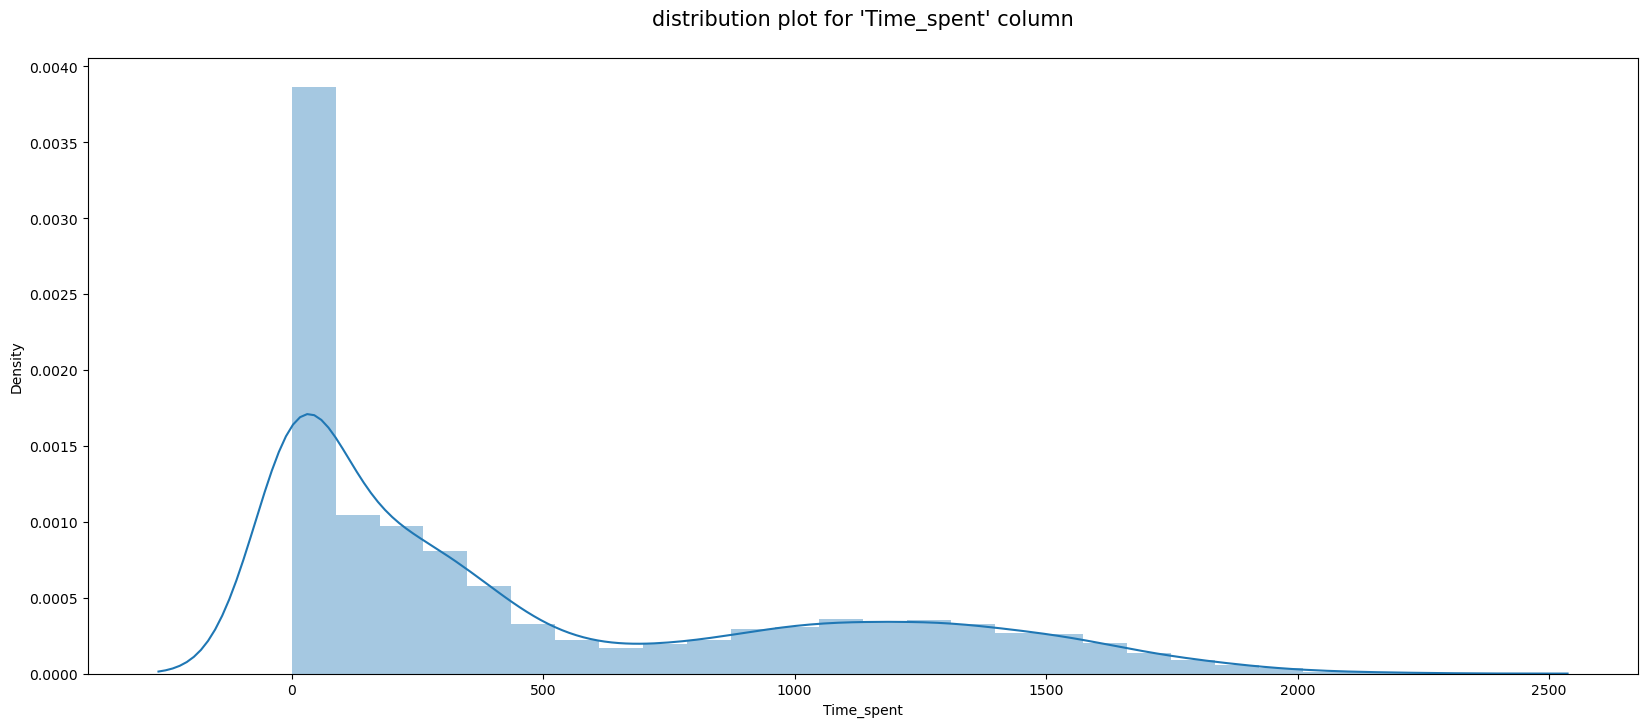


..................................................
distribution plot for 'Time_spent' column



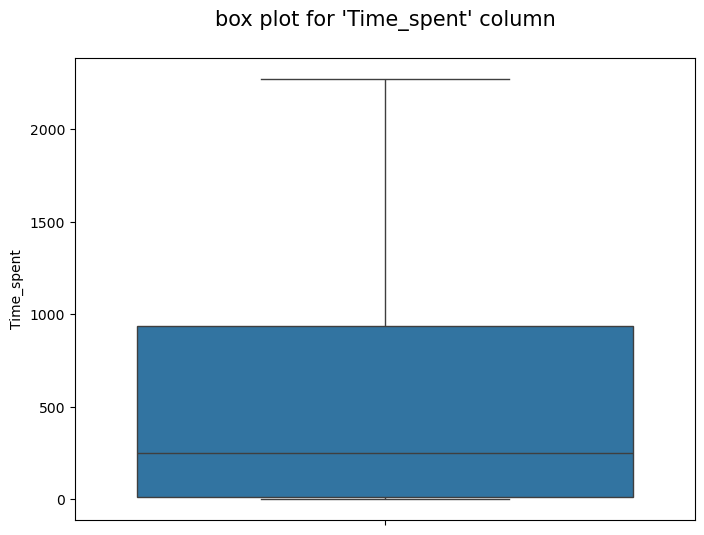


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
statistical summary of 'Page_views' column:

count    9240.000000
mean        2.327787
std         2.164258
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page_views, dtype: float64
..................................................
minimum value of 'Page_views' column: 0.0

maximum value of 'Page_views' column: 55.0

..................................................
distribution plot for 'Page_views' column



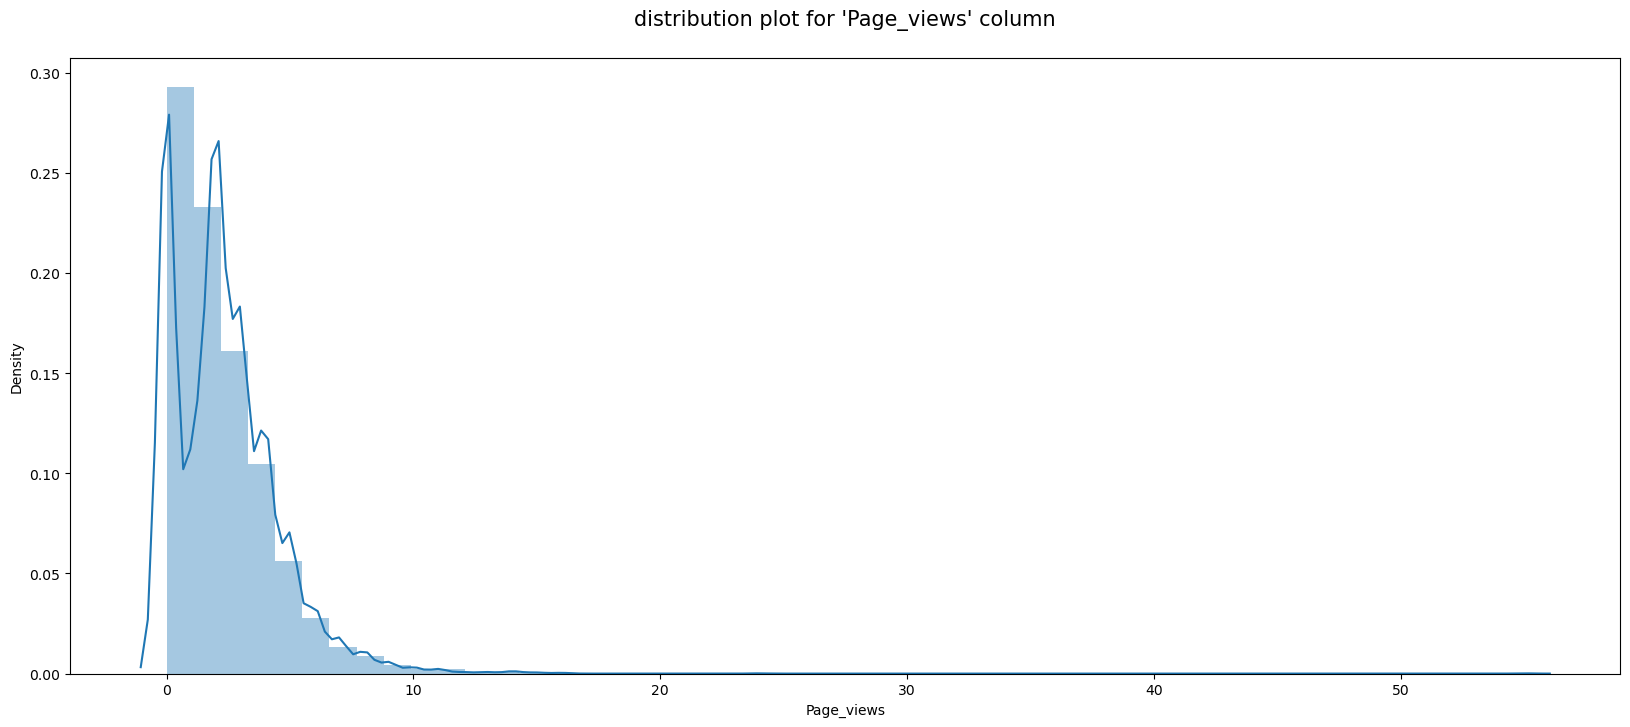


..................................................
distribution plot for 'Page_views' column



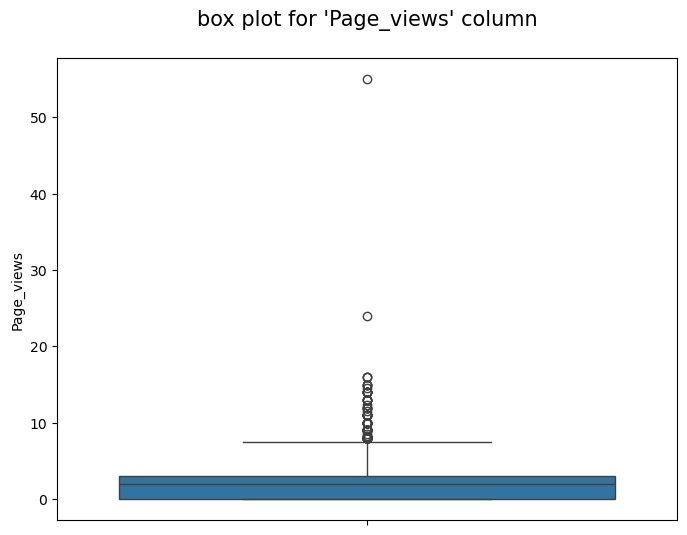


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [403]:
# getting insights from numerical variables 

for col in lead_score.columns:
    if lead_score[col].dtype == 'int64' or lead_score[col].dtype == 'float64':
        print('statistical summary of \'{}\' column:'.format(col))
        print()
        print(lead_score[col].describe())
        print('.'*50)
        print('minimum value of \'{}\' column:'.format(col),lead_score[col].min())
        print()
        print('maximum value of \'{}\' column:'.format(col),lead_score[col].max())
        print()
        print('.'*50)
        print('distribution plot for \'{}\' column\n'.format(col))
        plt.figure(figsize = [20,8])
        plt.title('distribution plot for \'{}\' column\n'.format(col),fontdict = {'fontsize':15,'color':'k'})
        sns.distplot(lead_score[col])
        plt.show()
        print()
        print('.'*50)
        print('distribution plot for \'{}\' column\n'.format(col))
        plt.figure(figsize = [8,6])
        plt.title('box plot for \'{}\' column\n'.format(col),fontdict = {'fontsize':15,'color':'k'})
        sns.boxplot(y = lead_score[col])
        plt.show()
        print()
        print('X'*60)

### inferences 

1. Total visits on website & Page views per visit
2. There are outliers in these columns which needs to be treated

## handling outliers 

In [404]:
# column 'totalvisits' have outliers so dropping those records which have value more than 40 

lead_score = lead_score[~(lead_score['TotalVisits']>40)]

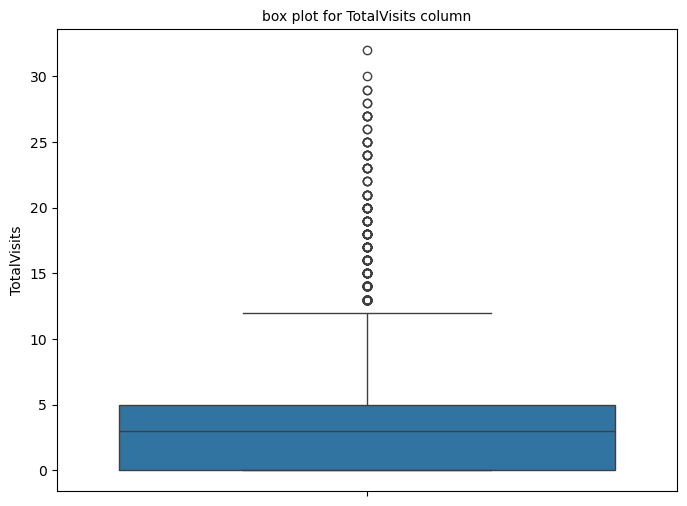

In [405]:
# cross-verifying for checking that outliers removed or not 

plt.figure(figsize = [8,6])
plt.title('box plot for TotalVisits column',fontdict = {'fontsize':10,'color':'k'})
sns.boxplot(y = lead_score['TotalVisits'])
plt.show()

In [406]:
# column 'Page_views' have outliers so dropping those records which have value more than 10

lead_score = lead_score[~(lead_score['Page_views']>10)]

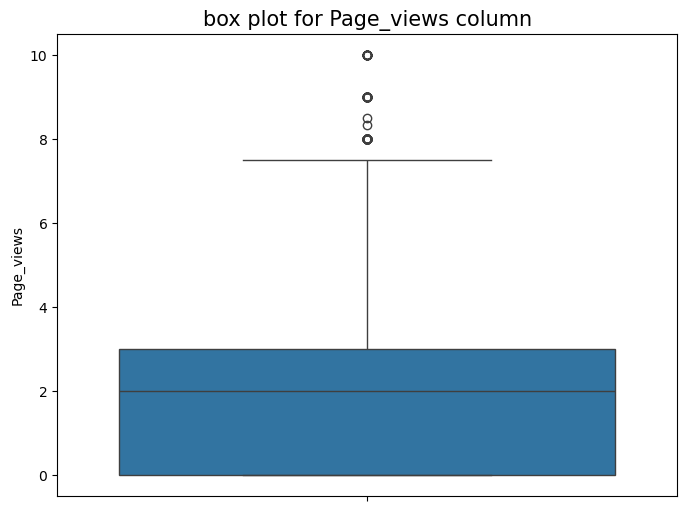

In [407]:
# cross-verifying for checking that outliers removed or not 

plt.figure(figsize = [8,6])
plt.title('box plot for Page_views column',fontdict = {'fontsize':15,'color':'k'})
sns.boxplot(y = lead_score['Page_views'])
plt.show()

## bivariate analysis 

### numerical - numerical 

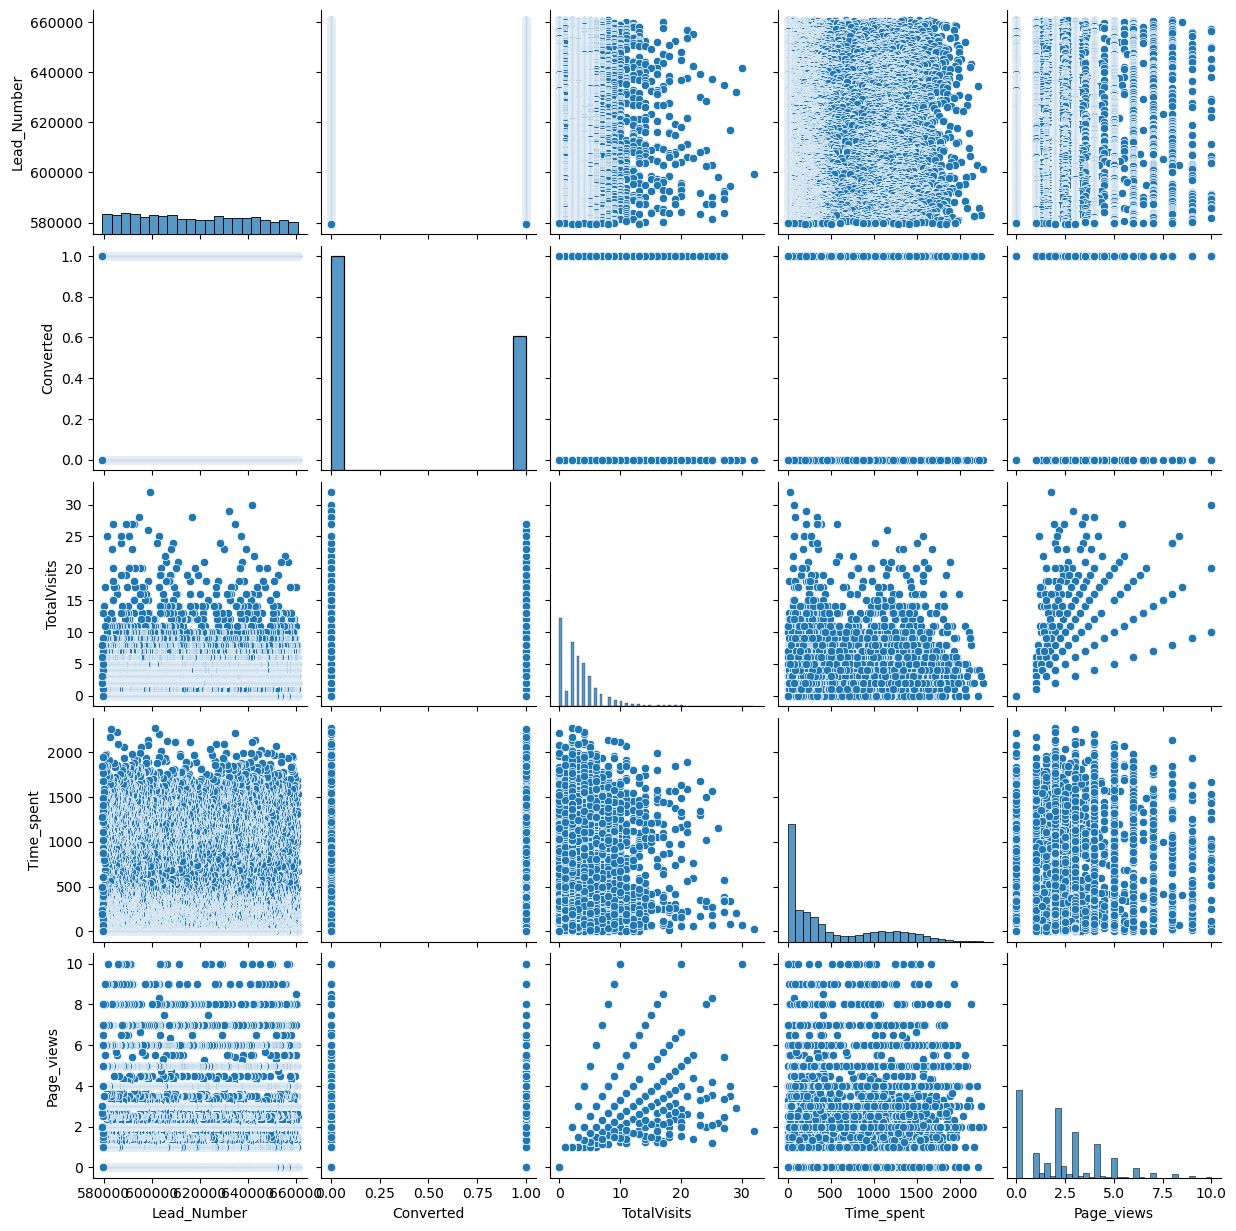

In [408]:
# plotting pair plot 

sns.pairplot(data = lead_score)
plt.show()

In [409]:
# making a list of categorical columns  

col = []
for cols in lead_score.columns:
    if lead_score[cols].dtype == 'int64' or lead_score[cols].dtype == 'float64':
        col.append(cols)

print(col)

['Lead_Number', 'Converted', 'TotalVisits', 'Time_spent', 'Page_views']


### numerical - categorical analysis

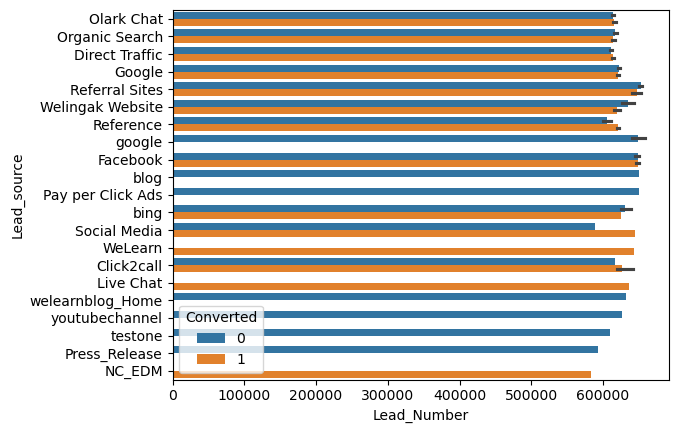

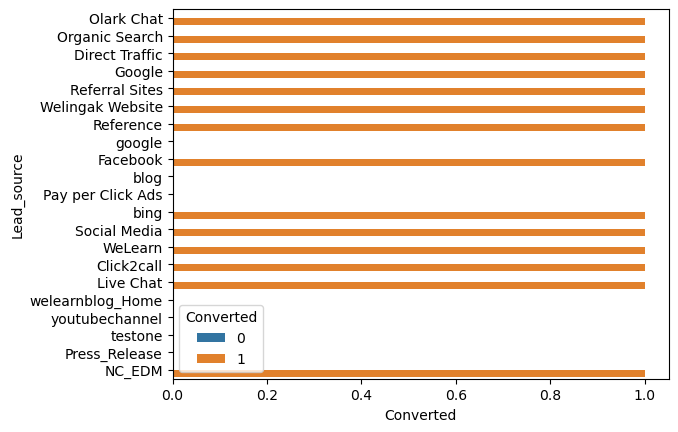

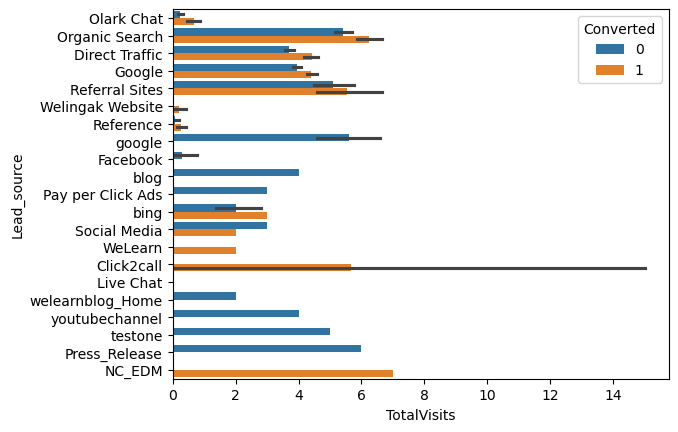

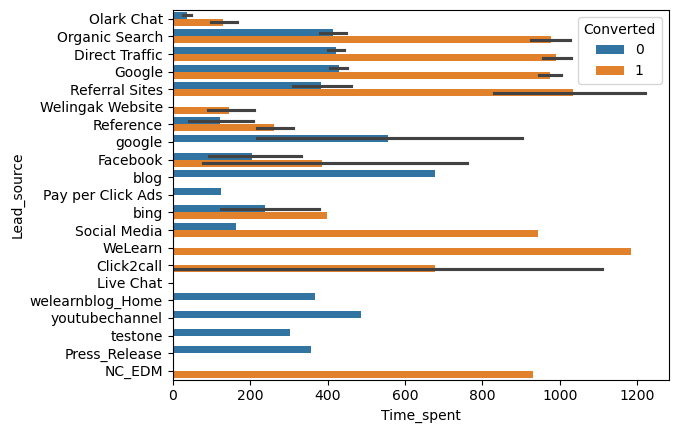

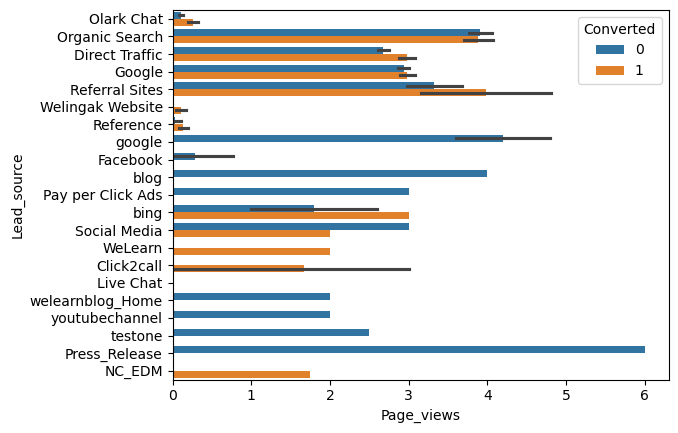

In [410]:

for plot in col:
    sns.barplot(data = lead_score , y = 'Lead_source' , x = lead_score[plot] , hue = 'Converted' )
    plt.show()

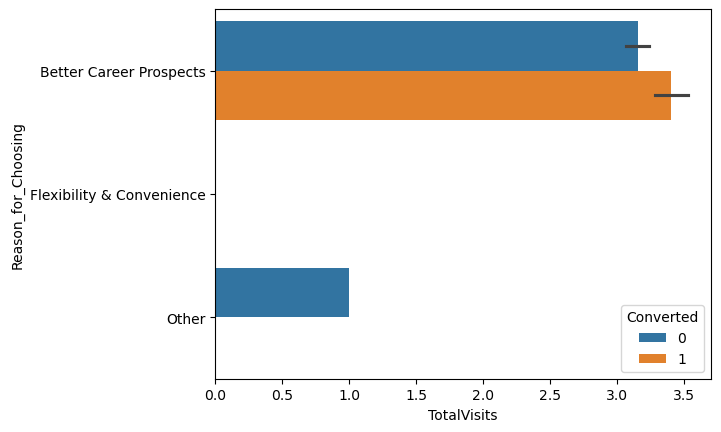

In [411]:
sns.barplot(data = lead_score , y = 'Reason_for_Choosing' , x = 'TotalVisits' , hue = 'Converted' )
plt.show()

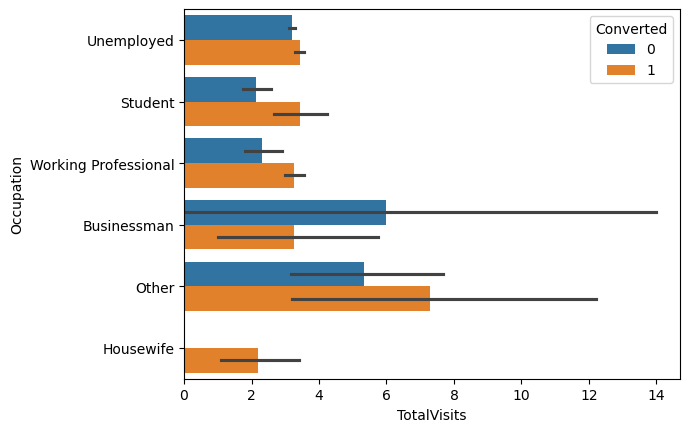

In [412]:
sns.barplot(data = lead_score , y = 'Occupation' , x = 'TotalVisits' , hue = 'Converted' )
plt.show()

In [413]:
lead_score.dtypes

Lead_Number                int64
Lead_Origin               object
Lead_source               object
No_email                  object
No_calls                  object
Converted                  int64
TotalVisits              float64
Time_spent                 int64
Page_views               float64
Country                   object
Specialization            object
got information           object
Occupation                object
Reason_for_Choosing       object
Search                    object
Magazine                  object
News_article              object
Forums                    object
Newspaper                 object
Ads                       object
Recommendation            object
Course_updates            object
Tags                      object
Content_updates           object
Lead Profile              object
City                      object
Pay_cheque                object
Free_copy                 object
Last_notable_activity     object
dtype: object

In [414]:
# making a list of numerical columns 

num_lead_score = lead_score[['Lead_Number','Converted','TotalVisits','Time_spent','Page_views']]

### heatmap 

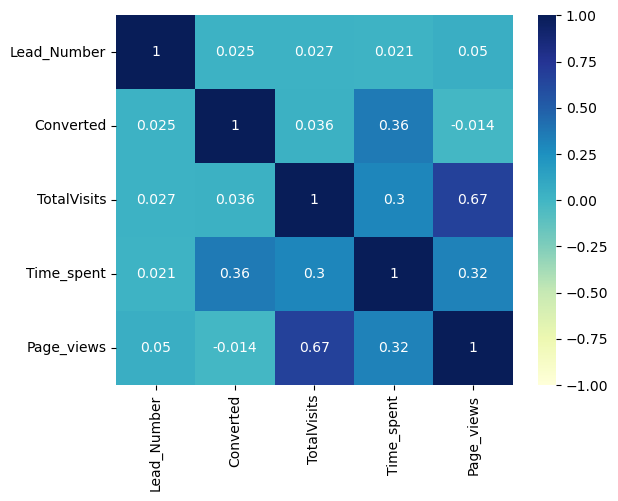

In [415]:
# plotting heatmap between correlations of numerical column 

correlation = num_lead_score.corr()
sns.heatmap(correlation,cmap='YlGnBu',vmin=-1.0,vmax=1.0,center=0,annot=True)
plt.show()

### inferences 

* Numeric-Numeric
1. There seems to be a linear relationship between TotalVisits and Pages vewed per visit
* Numeric-Categorical
1. Leads who are sourced from organic search have high page views per visit and have the highest conversion, followed by Google and Direct Traffic
2. Leads who are sourced from organic search have spent most of the time on website and have the highest conversion, followed by Google and Direct Traffic
3. Leads who are sourced from organic search have most number of visits on the website and have the highest conversion, followed by Google and Direct Traffic
4. Leads who are choosing the services for better prospects have high conversion
* Heatmap
1. There is high positive correlation between TotalVists and Pages vewed per visit

In [416]:
# checking the dataframe 

lead_score.head()

,Lead_Number,Lead_Origin,Lead_source,No_email,No_calls,Converted,TotalVisits,Time_spent,Page_views,Country,Specialization,got information,Occupation,Reason_for_Choosing,Search,Magazine,News_article,Forums,Newspaper,Ads,Recommendation,Course_updates,Tags,Content_updates,Lead Profile,City,Pay_cheque,Free_copy,Last_notable_activity
0,660737,API,Olark Chat,No,No,0,0.0,0,0.0,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,Select,Select,No,No,Modified
1,660728,API,Organic Search,No,No,0,5.0,674,2.5,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,Select,Select,No,No,Email Opened
2,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,Potential Lead,Mumbai,No,Yes,Email Opened
3,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,Select,Mumbai,No,No,Modified
4,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,Select,Mumbai,No,No,Modified


In [417]:
# checking datatype of columns 

lead_score.dtypes

Lead_Number                int64
Lead_Origin               object
Lead_source               object
No_email                  object
No_calls                  object
Converted                  int64
TotalVisits              float64
Time_spent                 int64
Page_views               float64
Country                   object
Specialization            object
got information           object
Occupation                object
Reason_for_Choosing       object
Search                    object
Magazine                  object
News_article              object
Forums                    object
Newspaper                 object
Ads                       object
Recommendation            object
Course_updates            object
Tags                      object
Content_updates           object
Lead Profile              object
City                      object
Pay_cheque                object
Free_copy                 object
Last_notable_activity     object
dtype: object

In [418]:
# making a list of categorical columns

categorical_cols = []
for col in lead_score.columns:
    if lead_score[col].dtype == 'object':
        categorical_cols.append(col)

print(categorical_cols)

['Lead_Origin', 'Lead_source', 'No_email', 'No_calls', 'Country', 'Specialization', 'got information', 'Occupation', 'Reason_for_Choosing', 'Search', 'Magazine', 'News_article', 'Forums', 'Newspaper', 'Ads', 'Recommendation', 'Course_updates', 'Tags', 'Content_updates', 'Lead Profile', 'City', 'Pay_cheque', 'Free_copy', 'Last_notable_activity']


# 5. Creating dummy variables

In [419]:
# making dummy for categorical variables 

lead_score = pd.get_dummies(lead_score, columns = categorical_cols,drop_first = True , dtype = 'int')


In [420]:
# checking the dataframe 

lead_score.head()

,Lead_Number,Converted,TotalVisits,Time_spent,Page_views,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Lead_Origin_Quick Add Form,Lead_source_Direct Traffic,Lead_source_Facebook,Lead_source_Google,Lead_source_Live Chat,Lead_source_NC_EDM,Lead_source_Olark Chat,Lead_source_Organic Search,Lead_source_Pay per Click Ads,Lead_source_Press_Release,Lead_source_Reference,Lead_source_Referral Sites,Lead_source_Social Media,Lead_source_WeLearn,Lead_source_Welingak Website,Lead_source_bing,Lead_source_blog,Lead_source_google,Lead_source_testone,Lead_source_welearnblog_Home,Lead_source_youtubechannel,No_email_Yes,No_calls_Yes,Country_Australia,Country_Bahrain,Country_Bangladesh,Country_Belgium,Country_Canada,Country_China,Country_Denmark,Country_France,Country_Germany,Country_Ghana,Country_Hong Kong,Country_India,Country_Indonesia,Country_Italy,Country_Kenya,Country_Kuwait,Country_Liberia,Country_Malaysia,Country_Netherlands,...,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Profile_Lateral Student,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Select,Lead Profile_Student of SomeSchool,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Free_copy_Yes,Last_notable_activity_Email Bounced,Last_notable_activity_Email Link Clicked,Last_notable_activity_Email Marked Spam,Last_notable_activity_Email Opened,Last_notable_activity_Email Received,Last_notable_activity_Form Submitted on Website,Last_notable_activity_Had a Phone Conversation,Last_notable_activity_Modified,Last_notable_activity_Olark Chat Conversation,Last_notable_activity_Page Visited on Website,Last_notable_activity_Resubscribed to emails,Last_notable_activity_SMS Sent,Last_notable_activity_Unreachable,Last_notable_activity_Unsubscribed,Last_notable_activity_View in browser link Clicked
0,660737,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,660728,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,660727,1,2.0,1532,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,660719,0,1.0,305,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,660681,1,2.0,1428,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [421]:
# as we don't need 'lead_number' for analysis so making it a index 

lead_score = lead_score.set_index('Lead_Number',drop = True)

In [422]:
# checking the dataframe 

lead_score.head()

,Converted,TotalVisits,Time_spent,Page_views,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Lead_Origin_Quick Add Form,Lead_source_Direct Traffic,Lead_source_Facebook,Lead_source_Google,Lead_source_Live Chat,Lead_source_NC_EDM,Lead_source_Olark Chat,Lead_source_Organic Search,Lead_source_Pay per Click Ads,Lead_source_Press_Release,Lead_source_Reference,Lead_source_Referral Sites,Lead_source_Social Media,Lead_source_WeLearn,Lead_source_Welingak Website,Lead_source_bing,Lead_source_blog,Lead_source_google,Lead_source_testone,Lead_source_welearnblog_Home,Lead_source_youtubechannel,No_email_Yes,No_calls_Yes,Country_Australia,Country_Bahrain,Country_Bangladesh,Country_Belgium,Country_Canada,Country_China,Country_Denmark,Country_France,Country_Germany,Country_Ghana,Country_Hong Kong,Country_India,Country_Indonesia,Country_Italy,Country_Kenya,Country_Kuwait,Country_Liberia,Country_Malaysia,Country_Netherlands,Country_Nigeria,...,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Profile_Lateral Student,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Select,Lead Profile_Student of SomeSchool,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Free_copy_Yes,Last_notable_activity_Email Bounced,Last_notable_activity_Email Link Clicked,Last_notable_activity_Email Marked Spam,Last_notable_activity_Email Opened,Last_notable_activity_Email Received,Last_notable_activity_Form Submitted on Website,Last_notable_activity_Had a Phone Conversation,Last_notable_activity_Modified,Last_notable_activity_Olark Chat Conversation,Last_notable_activity_Page Visited on Website,Last_notable_activity_Resubscribed to emails,Last_notable_activity_SMS Sent,Last_notable_activity_Unreachable,Last_notable_activity_Unsubscribed,Last_notable_activity_View in browser link Clicked
Lead_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
660737,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
660728,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
660727,1,2.0,1532,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
660719,0,1.0,305,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
660681,1,2.0,1428,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### defining X & y variable 

In [423]:
y = lead_score.pop('Converted')
X = lead_score

In [424]:
# checking shape of the data 

y.shape

(9183,)

In [425]:
X.shape

(9183, 158)

# splitting the dataframe into train & test sets 

In [426]:
# making train-test-split 

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.7,random_state = 100)

In [427]:
# checking shape of dataframes 

print('Shape of X_train: ',X_train.shape)
print('Shape of X_test: ',X_test.shape)
print('Shape of y_train: ',y_train.shape)
print('Shape of y_test: ',y_test.shape)

Shape of X_train:  (6428, 158)
Shape of X_test:  (2755, 158)
Shape of y_train:  (6428,)
Shape of y_test:  (2755,)


# 6. rescaling numeric features 

In [428]:
# making a variable called features for scaling 

features = ['TotalVisits','Time_spent','Page_views']

In [429]:
scaler = MinMaxScaler()

In [430]:
# scaling the numeric data 

X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

# 7. Feature Elimination using RFE

In [431]:
# building the model using RFE 

rfe = RFE(estimator = LogisticRegression(),n_features_to_select = 15)
rfe.fit(X_train,y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('TotalVisits', False, 16),
 ('Time_spent', True, 1),
 ('Page_views', False, 29),
 ('Lead_Origin_Landing Page Submission', False, 80),
 ('Lead_Origin_Lead Add Form', True, 1),
 ('Lead_Origin_Lead Import', False, 15),
 ('Lead_Origin_Quick Add Form', False, 72),
 ('Lead_source_Direct Traffic', False, 49),
 ('Lead_source_Facebook', False, 97),
 ('Lead_source_Google', False, 53),
 ('Lead_source_Live Chat', False, 113),
 ('Lead_source_NC_EDM', False, 59),
 ('Lead_source_Olark Chat', False, 17),
 ('Lead_source_Organic Search', False, 51),
 ('Lead_source_Pay per Click Ads', False, 136),
 ('Lead_source_Press_Release', False, 139),
 ('Lead_source_Reference', False, 50),
 ('Lead_source_Referral Sites', False, 52),
 ('Lead_source_Social Media', False, 125),
 ('Lead_source_WeLearn', False, 112),
 ('Lead_source_Welingak Website', True, 1),
 ('Lead_source_bing', False, 103),
 ('Lead_source_blog', False, 140),
 ('Lead_source_google', False, 64),
 ('Lead_source_testone', False, 123),
 ('Lead_source_w

In [432]:
# columns selected by RFE 

cols = X_train.columns[rfe.support_]

In [433]:
X_train = X_train[cols]
X_test = X_test[cols]

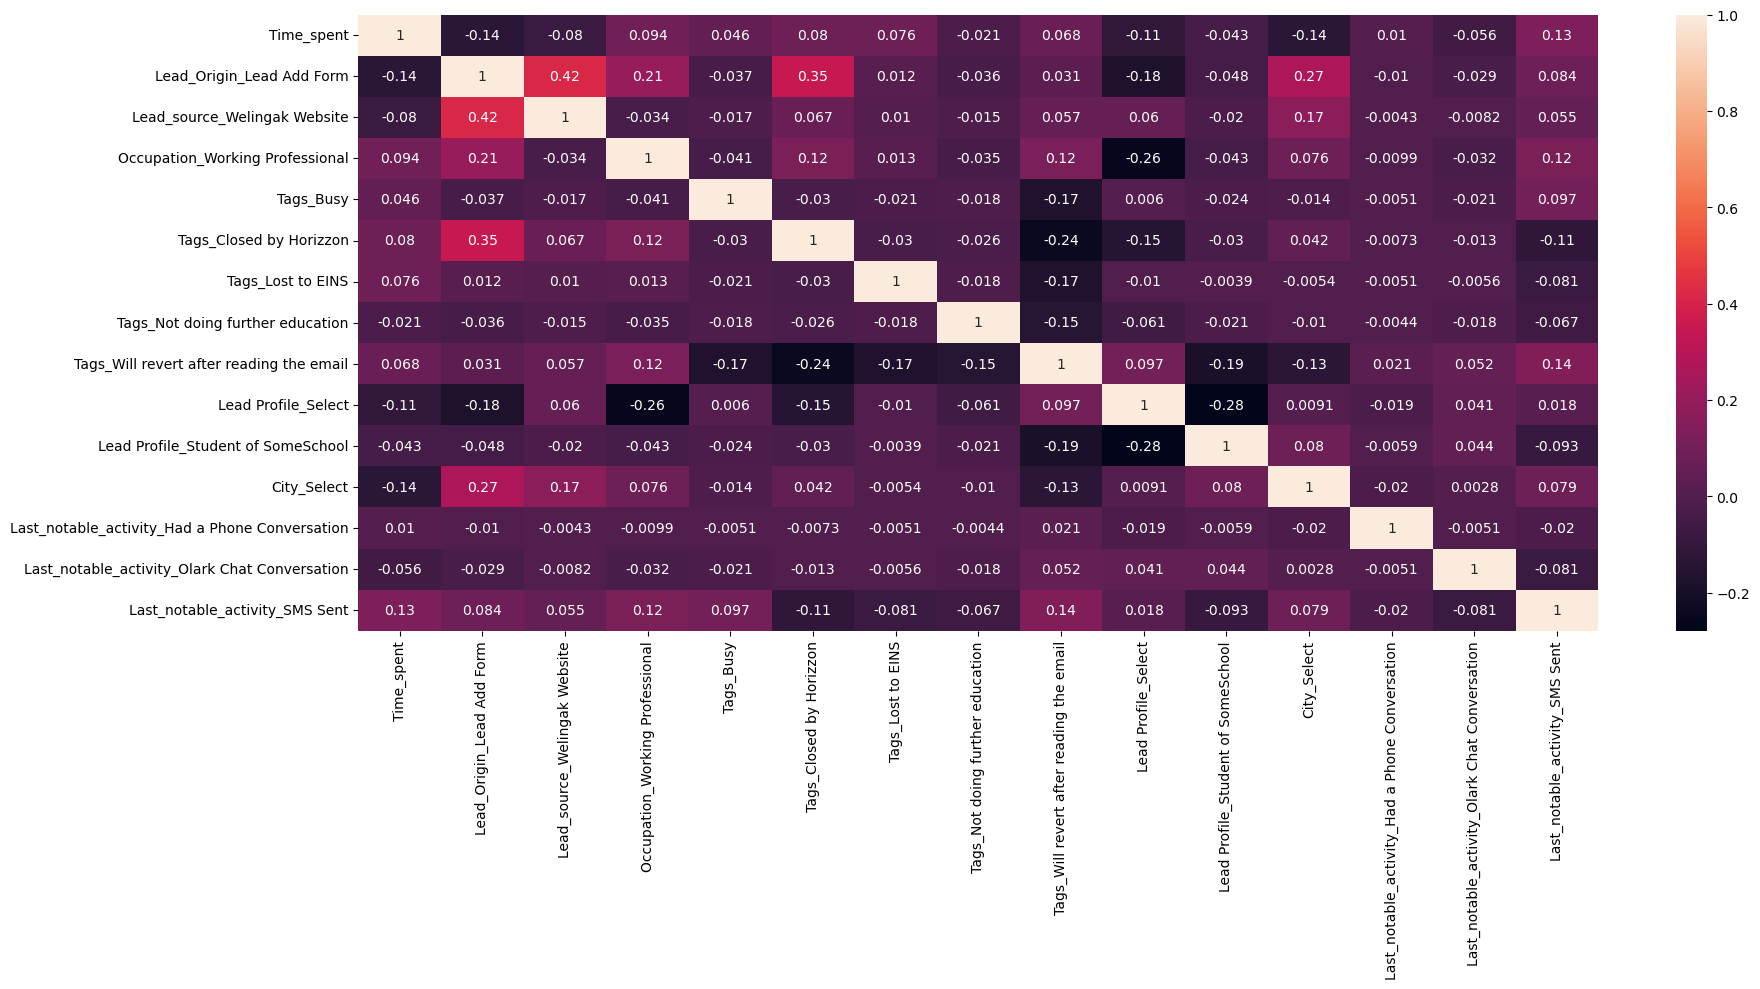

In [467]:
plt.figure(figsize = [20,8])
sns.heatmap(X_train.corr(),annot = True)
plt.show()

# 8. Model Building

In [435]:
# Checking VIF

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
8,Tags_Will revert after reading the email,2.611706
9,Lead Profile_Select,2.571725
0,Time_spent,1.823880
1,Lead_Origin_Lead Add Form,1.773756
11,City_Select,1.474037
14,Last_notable_activity_SMS Sent,1.464369
5,Tags_Closed by Horizzon,1.350814
2,Lead_source_Welingak Website,1.275356
3,Occupation_Working Professional,1.257294
6,Tags_Lost to EINS,1.075453


In [436]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [437]:
lm = sm.GLM(y_train,X_train_sm,family = sm.families.Binomial()).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6428
Model:                            GLM   Df Residuals:                     6412
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1473.8
Date:                Tue, 17 Sep 2024   Deviance:                       2947.7
Time:                        18:17:53   Pearson chi2:                 2.23e+04
No. Iterations:                    24   Pseudo R-squ. (CS):             0.5839
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -4.6266      0.190    -24.319      0.000      -5.000      -4.254
Time_spent                                         4.2574      0.205     20.763      0.000       3.855       4.659
Lead_Origin_Lead Add Form                          1.2855      0.286      4.497      0.000       0.725       1.846
Lead_source_Welingak Website                       2.3736      0.794      2.989      0.003       0.817       3.930
Occupation_Working Professional                    2.1177      0.295      7.172      0.000       1.539       2.696
Tags_Busy                                          3.9488      0.288     13.712      0.000       3.384       4.513
Tags_Closed by Horizzon                           10.3014      1.037      9.933      0.000       8.269      12.334
Tags_Lost to EINS                                  9.3921      0.564     16.660      0.000       8.287      10.497
Tags_Not doing further education                 -21.8106   1.82e+04     -0.001      0.999   -3.58e+04    3.57e+04
Tags_Will revert after reading the email           5.2759      0.190     27.699      0.000       4.903       5.649
Lead Profile_Select                               -3.1818      0.151    -21.050      0.000      -3.478      -2.886
Lead Profile_Student of SomeSchool                -2.7089      0.781     -3.470      0.001      -4.239      -1.179
City_Select                                        1.9128      0.127     15.102      0.000       1.665       2.161
Last_notable_activity_Had a Phone Conversation     3.9171      1.257      3.116      0.002       1.454       6.381
Last_notable_activity_Olark Chat Conversation     -1.4612      0.426     -3.426      0.001      -2.297      -0.625
Last_notable_activity_SMS Sent                     2.7184      0.119     22.935      0.000       2.486       2.951
==================================================================================================================
"""

In [438]:
# making predictions on test set 

y_train_pred = lm.predict(X_train_sm)
y_train_pred.head()

Lead_Number
626353    0.002744
588102    0.999831
641543    0.107325
642145    0.875855
630816    0.875785
dtype: float64

In [439]:
# making a dataframe on predicted train set  

y_train_pred_df = pd.DataFrame({'Lead_Number':y_train_pred.index,'converted':y_train.values,'converted_prob':y_train_pred.values})
y_train_pred_df.head()

,Lead_Number,converted,converted_prob
0,626353,0,0.002744
1,588102,1,0.999831
2,641543,0,0.107325
3,642145,1,0.875855
4,630816,1,0.875785


In [440]:
y_train_pred_df['prediction'] = y_train_pred_df.converted_prob.map(lambda x: 1 if x>0.5 else 0)
y_train_pred_df.head()

,Lead_Number,converted,converted_prob,prediction
0,626353,0,0.002744,0
1,588102,1,0.999831,1
2,641543,0,0.107325,0
3,642145,1,0.875855,1
4,630816,1,0.875785,1


# 9. Metrics on Training set and Finding Optimum Cutoff Probability

### confusion matrix of train set

In [441]:
 

confusion_matrix = metrics.confusion_matrix(y_train_pred_df.converted,y_train_pred_df.prediction)
print(confusion_matrix)

[[3700  236]
 [ 331 2161]]


### accuracy score of train set

In [442]:
 

accu_score = round(metrics.accuracy_score(y_train_pred_df.converted,y_train_pred_df.prediction),2)
print(accu_score)

0.91


In [443]:
TP = confusion_matrix[1,1] #True Positives
TN = confusion_matrix[0,0] #True Negatives
FP = confusion_matrix[0,1] #False Positives
FN = confusion_matrix[1,0] #False Negatives

### sensitivty

In [444]:
 

sensitivity = round(TP/float(TP + FN),2)
print(sensitivity)

0.87


### specificity

In [445]:
 

specificity = round(TN/float(TN + FP),2)
print(specificity)

0.94


### checking classification report

In [446]:
 

print(classification_report(y_train_pred_df.converted,y_train_pred_df.prediction))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3936
           1       0.90      0.87      0.88      2492

    accuracy                           0.91      6428
   macro avg       0.91      0.90      0.91      6428
weighted avg       0.91      0.91      0.91      6428



In [447]:
# making a function for drawing ROC curve 

def draw_roc(actual,probs):
    fpr,tpr,thresolds = metrics.roc_curve(actual,probs,drop_intermediate = False)
    auc_score = metrics.roc_auc_score(actual,probs)
    plt.figure(figsize = (5,5))
    plt.plot(fpr , tpr , label = "ROC_curve (area = %0.2f)" %  auc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None
    
    

### ROC curve 

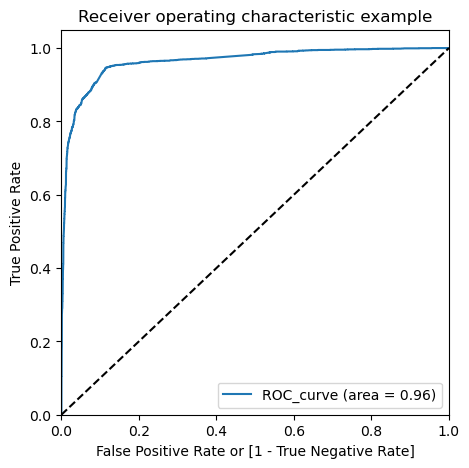

In [448]:
draw_roc(y_train_pred_df.converted, y_train_pred_df.converted_prob)

### Finding Optimal Cutoff probability

In [449]:
# making a list of float numbers for getting cut-off value 

num =[float(i/10) for i in range(10)]
for i in num:
    y_train_pred_df[i] = y_train_pred_df.converted_prob.map(lambda x: 1 if x>i else 0)
    
y_train_pred_df.head()   

,Lead_Number,converted,converted_prob,prediction,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,626353,0,0.002744,0,1,0,0,0,0,0,0,0,0,0
1,588102,1,0.999831,1,1,1,1,1,1,1,1,1,1,1
2,641543,0,0.107325,0,1,1,0,0,0,0,0,0,0,0
3,642145,1,0.875855,1,1,1,1,1,1,1,1,1,1,0
4,630816,1,0.875785,1,1,1,1,1,1,1,1,1,1,0


### Probabilty, Accuracy, Sensitivity, and Specificity at different cut-offs

In [450]:
# making a dataframe for checking parameters on different cut-off values 

cut_off = pd.DataFrame(columns = ['probability','accuracy','sensitivity','specificity'])

In [451]:
num =[float(i/10) for i in range(10)]
for i in num:
    cm_1 = metrics.confusion_matrix(y_train_pred_df.converted,y_train_pred_df[i])
    total = sum(sum(cm_1))
    accuracy = (cm_1[0,0]+cm_1[1,1])/total
    specificity = cm_1[0,0]/(cm_1[0,0]+cm_1[0,1])
    sensitivity = cm_1[1,1]/(cm_1[1,0]+cm_1[1,1])
    cut_off.loc[i] = [ i ,accuracy,sensitivity,specificity]

print(cut_off)



     probability  accuracy  sensitivity  specificity
0.0          0.0  0.387679     1.000000     0.000000
0.1          0.1  0.821562     0.965490     0.730437
0.2          0.2  0.900591     0.951043     0.868648
0.3          0.3  0.908525     0.937801     0.889990
0.4          0.4  0.910236     0.894864     0.919970
0.5          0.5  0.911792     0.867175     0.940041
0.6          0.6  0.911481     0.833868     0.960620
0.7          0.7  0.898880     0.784510     0.971291
0.8          0.8  0.888768     0.741172     0.982215
0.9          0.9  0.845520     0.618780     0.989075


### Visualisation of the relation between the metrics

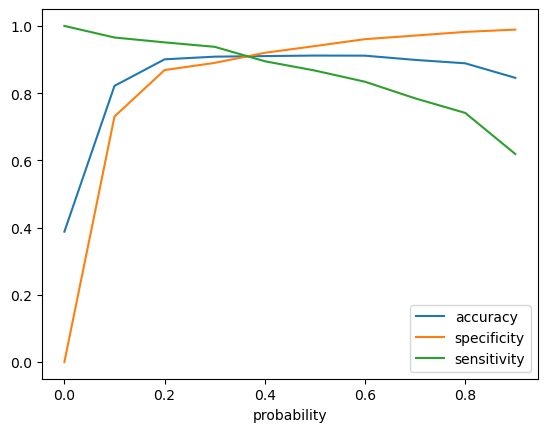

In [452]:
# plotting line graph for checking accuracy,specificity,sensitivity for different probabilities 

cut_off.plot.line(x = 'probability', y = ['accuracy','specificity','sensitivity'])
plt.show()

### Precision and Recall tradeoff

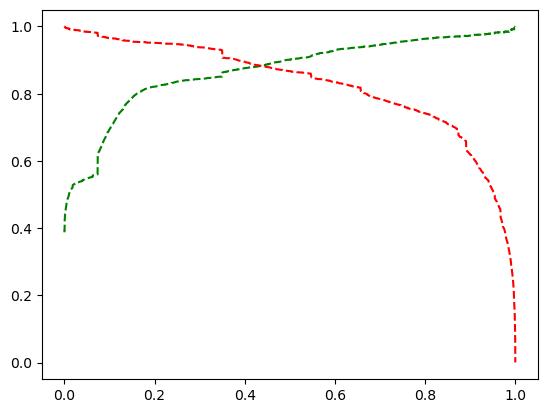

In [453]:
precision , recall , thresolds = precision_recall_curve(y_train_pred_df.converted, y_train_pred_df.converted_prob)
plt.plot(thresolds,precision[:-1],'g--')
plt.plot(thresolds,recall[:-1],'r--')
plt.show()

### Selecting 0.4 as optimized cutoff point from the above graph

### 10. Making Predictions on Test Set

In [454]:
# making prediction on test set 

y_test_pred = lm.predict(X_test_sm)

y_test_pred

Lead_Number
589943    2.743927e-03
585377    3.498568e-01
588865    5.823971e-01
655140    4.990517e-04
619314    9.996256e-01
              ...     
607902    8.516016e-04
633407    8.737818e-01
655079    8.378960e-02
586285    1.919826e-12
655068    6.633936e-04
Length: 2755, dtype: float64

In [455]:
# making a dataframe for test set 

y_test_pred_df = pd.DataFrame({'Lead_Number':y_test.index,'Converted':y_test.values,'Predicted_Prob':y_test_pred.values})

y_test_pred_df.head()

,Lead_Number,Converted,Predicted_Prob
0,589943,0,0.002744
1,585377,0,0.349857
2,588865,1,0.582397
3,655140,0,0.000499
4,619314,1,0.999626


In [456]:
y_test_pred_df['Converted_Prediction'] = y_test_pred_df.Predicted_Prob.map(lambda x : 1 if x > 0.4 else 0)

y_test_pred_df.head()

,Lead_Number,Converted,Predicted_Prob,Converted_Prediction
0,589943,0,0.002744,0
1,585377,0,0.349857,0
2,588865,1,0.582397,1
3,655140,0,0.000499,0
4,619314,1,0.999626,1


### accuracy score

In [457]:
 

accu_score_test = round(metrics.accuracy_score(y_test_pred_df.Converted, y_test_pred_df.Converted_Prediction),3)

accu_score_test

0.913

### sensitivity

In [458]:

sensitivity = round(TP/float(TP + FN),2)
print(sensitivity)

0.87


### specificity 

In [459]:


specificity = round(TN/float(TN + FP),2)
print(specificity)

0.94


### classification report

In [460]:
 

print(classification_report(y_train_pred_df.converted,y_train_pred_df.prediction))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3936
           1       0.90      0.87      0.88      2492

    accuracy                           0.91      6428
   macro avg       0.91      0.90      0.91      6428
weighted avg       0.91      0.91      0.91      6428



### final lead score dataframe for train set

In [461]:
 

y_train_pred_df['lead_score'] = y_train_pred_df.converted_prob.map(lambda x: round(x*100))

In [462]:
train_lead_score = y_train_pred_df[['Lead_Number','lead_score']]

In [463]:
# checking the dataframe 

train_lead_score.head()

,Lead_Number,lead_score
0,626353,0
1,588102,100
2,641543,11
3,642145,88
4,630816,88


### final lead score dataframe for test set


In [464]:

y_test_pred_df['lead_score'] = y_test_pred_df.Predicted_Prob.map(lambda x: round(x*100))

In [465]:
test_lead_score = y_test_pred_df[['Lead_Number','lead_score']]

In [466]:
# checking the dataframe 

test_lead_score.head()

,Lead_Number,lead_score
0,589943,0
1,585377,35
2,588865,58
3,655140,0
4,619314,100
